# Movie Revenue Prediction - UMLND Capstone Project

Objective of this project is to __predict a movie revenue__ based on historic data about movie revenues and performance at global box office. 

Such a prediction would be useful for optimization in many areas during various stages of planning and production of movies, for instance, selection of actors, crew, location, production spend, marketing spend, logistics and so on. Predicting revenue potential would enable movie production enterprises make wise investment decisions, come up with movies with plots relevant to society, higher entertainment satisfaction and ultimately greater good of all the involved parties.

## Data Exploration

In this public competition hosted by Kaggle, I am presented with metadata on past films from The Movie Database to try and predict their overall worldwide box office revenue.  Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. 

Data is downloaded from this link https://www.kaggle.com/c/tmdb-box-office-prediction/data

Since the dataset is small enough, I made a local copy and checked in to git along with project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
import time
import json

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from wordcloud import WordCloud
import eli5
import shap
shap.initjs()

warnings.filterwarnings("ignore")
%matplotlib inline

### Read training dataset and explore to get familiarized with data

Review data structure, get a feel for data types and null values

In [2]:
train = pd.read_csv('data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

There are 3000 records in dataset, looking at data types and null values in few of the columns, it will be an interesting challenge with data exploration and exploratory data analysis.

Review test data set as well...

In [3]:
test = pd.read_csv('data/test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

## Exploratory data analysis (EDA)

Let us jump in to some exploratory data analysis, take a look at few records to get a feel of actual data.

We have some JSON key value pairs, free form text, categorical variables and continuous variables, as well as release date. Dream come true for aspiring ML Engineer to play with this kind of data!

In [4]:
train.head()

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                NaN   3300000   
3   4                                                NaN   1200000   
4   5                                                NaN         0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   
3  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   
3         http://kahaanithefilm.com/  tt1821480                hi   
4                                NaN  tt1380152                ko   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                      마린보이   

                                            overview  popularity    ...     \
0  When Lou, who has become the "father of the In...    6.575393    ...      
1  Mia Thermopolis is now a college graduate and ...    8.248895    ...      
2  Under the direction of a ruthless instructor, ...   64.299990    ...      
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936    ...      
4  Marine Boy is the story of a former national s...    1.148070    ...      

  release_date runtime                                   spoken_languages  \
0      2/20/15    93.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1       8/6/04   113.0           [{'iso_639_1': 'en', 'name': 'English'}]   
2     10/10/14   105.0           [{'iso_639_1': 'en', 'name': 'English'}]   
3       3/9/12   122.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
4       2/5/09   118.0           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]   

     status                                            tagline  \
0  Released  The Laws of Space and Time are About to be Vio...   
1  Released  It can take a lifetime to find true love; she'...   
2  Released    The road to greatness can take you to the edge.   
3  Released                                                NaN   
4  Released                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   
3  [{'id': 10092, 'name': 'mystery'}, {'id': 1054...   
4                                                NaN   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   
3  [{'cast_id': 1, 'character': 'Vidya Bagchi', '...   
4  [{'cast_id': 3, 'character': 'Chun-soo', 'cred...   

                                                crew   revenue  
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651  
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435  
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...  13092000  
3

Descriptive stats in train and test datasets.

In [5]:
train.describe(include='all')

id                              belongs_to_collection  \
count   3000.000000                                                604   
unique          NaN                                                422   
top             NaN  [{'id': 645, 'name': 'James Bond Collection', ...   
freq            NaN                                                 16   
mean    1500.500000                                                NaN   
std      866.169729                                                NaN   
min        1.000000                                                NaN   
25%      750.750000                                                NaN   
50%     1500.500000                                                NaN   
75%     2250.250000                                                NaN   
max     3000.000000                                                NaN   

              budget                         genres  \
count   3.000000e+03                           2993   
unique           NaN                            872   
top              NaN  [{'id': 18, 'name': 'Drama'}]   
freq             NaN                            266   
mean    2.253133e+07                            NaN   
std     3.702609e+07                            NaN   
min     0.000000e+00                            NaN   
25%     0.000000e+00                            NaN   
50%     8.000000e+06                            NaN   
75%     2.900000e+07                            NaN   
max     3.800000e+08                            NaN   

                                 homepage    imdb_id original_language  \
count                                 946       3000              3000   
unique                                941       3000                36   
top     http://www.transformersmovie.com/  tt0884224                en   
freq                                    4          1              2575   
mean                                  NaN        NaN               NaN   
std                                   NaN        NaN               NaN   
min                                   NaN        NaN               NaN   
25%                                   NaN        NaN               NaN   
50%                                   NaN        NaN               NaN   
75%                                   NaN        NaN               NaN   
max                                   NaN        NaN               NaN   

       original_title                                           overview  \
count            3000                                               2992   
unique           2975                                               2992   
top            Priest  Presumed dead after a shoot-out with the Haddo...   
freq                2                                                  1   
mean              NaN                                                NaN   
std               NaN                                                NaN   
min               NaN                                                NaN   
25%               NaN                                                NaN   
50%               NaN                                                NaN   
75%               NaN                                                NaN   
max               NaN                                                NaN   

         popularity      ...      release_date      runtime  \
count   3000.000000      ...              3000  2998.000000   
unique          NaN      ...              2398          NaN   
top             NaN      ...           9/10/10          NaN   
freq            NaN      ...                 5          NaN   
mean       8.463274      ...               NaN   107.856571   
std       12.104000      ...               NaN    22.086434   
min        0.000001      ...               NaN     0.000000   
25%        4.018053      ...               NaN    94.000000   
50%        7.374861      ...               NaN   104.000000   
75%       10.890983      ...       

In [6]:
test.describe(include='all')

id                              belongs_to_collection  \
count   4398.000000                                                877   
unique          NaN                                                556   
top             NaN  [{'id': 645, 'name': 'James Bond Collection', ...   
freq            NaN                                                 10   
mean    5199.500000                                                NaN   
std     1269.737571                                                NaN   
min     3001.000000                                                NaN   
25%     4100.250000                                                NaN   
50%     5199.500000                                                NaN   
75%     6298.750000                                                NaN   
max     7398.000000                                                NaN   

              budget                         genres  \
count   4.398000e+03                           4382   
unique           NaN                           1101   
top              NaN  [{'id': 18, 'name': 'Drama'}]   
freq             NaN                            348   
mean    2.264929e+07                            NaN   
std     3.689991e+07                            NaN   
min     0.000000e+00                            NaN   
25%     0.000000e+00                            NaN   
50%     7.450000e+06                            NaN   
75%     2.800000e+07                            NaN   
max     2.600000e+08                            NaN   

                           homepage    imdb_id original_language  \
count                          1420       4398              4398   
unique                         1402       4398                39   
top     http://www.kungfupanda.com/  tt5657028                en   
freq                              3          1              3776   
mean                            NaN        NaN               NaN   
std                             NaN        NaN               NaN   
min                             NaN        NaN               NaN   
25%                             NaN        NaN               NaN   
50%                             NaN        NaN               NaN   
75%                             NaN        NaN               NaN   
max                             NaN        NaN               NaN   

       original_title            overview   popularity  \
count            4398                4384  4398.000000   
unique           4353                4383          NaN   
top              Life  No overview found.          NaN   
freq                2                   2          NaN   
mean              NaN                 NaN     8.550230   
std               NaN                 NaN    12.209014   
min               NaN                 NaN     0.000001   
25%               NaN                 NaN     3.895186   
50%               NaN                 NaN     7.482241   
75%               NaN                 NaN    10.938524   
max               NaN                 NaN   547.488298   

                              ...                          \
count                         ...                           
unique                        ...                           
top                           ...                           
freq                          ...                           
mean                          ...                           
std                           ...                           
min                           ...                           
25%                           ...                           
50%                           ...                           
75%                           ...                           
max                           ...                           

                                     production_countries release_date  \
count                                                4296         4397   
unique                                                458         3289  

### Missing value analysis

Count of missing values in each column, in both train and test datasets. Gives an early indication on which columns need appropriate handling for missing values and strategies for handling them.

In [7]:
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [8]:
test.isna().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

## Data Profiling

Using __pandas_profiling__ to accelerate data exploration. For details on this module -> https://pandas-profiling.github.io/pandas-profiling/docs/

And a good article discussing advantages of using such package for data science efforts -> https://towardsdatascience.com/a-better-eda-with-pandas-profiling-e842a00e1136

In [9]:
import pandas_profiling
train.profile_report(style={'full_width':True})

### Visualizations to develop intuition

Joint plots to start visualizing relationships between numeric variables...

__Budget vs Revenue__


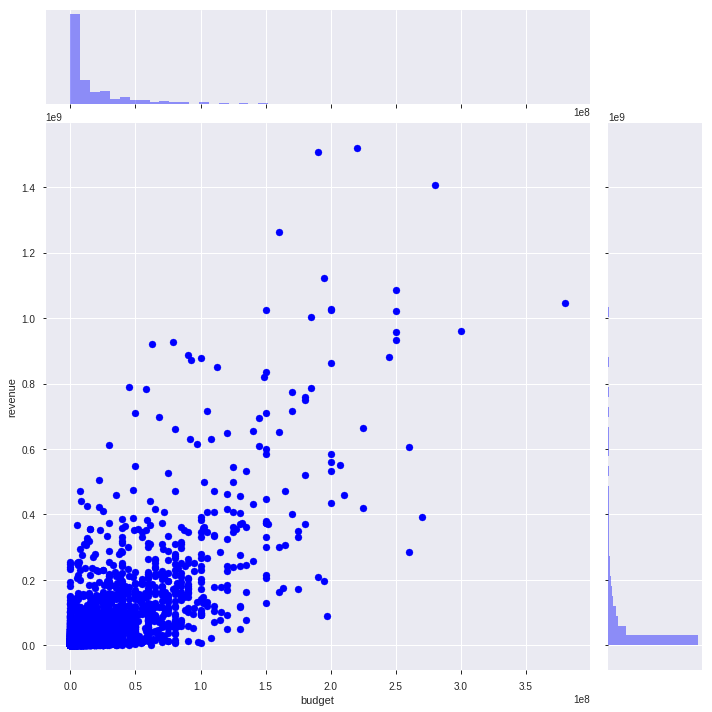

In [10]:
sns.jointplot(x="budget", y="revenue", data=train, height=10, ratio=5, color="b")
plt.show()


__Popularity vs Revenue__

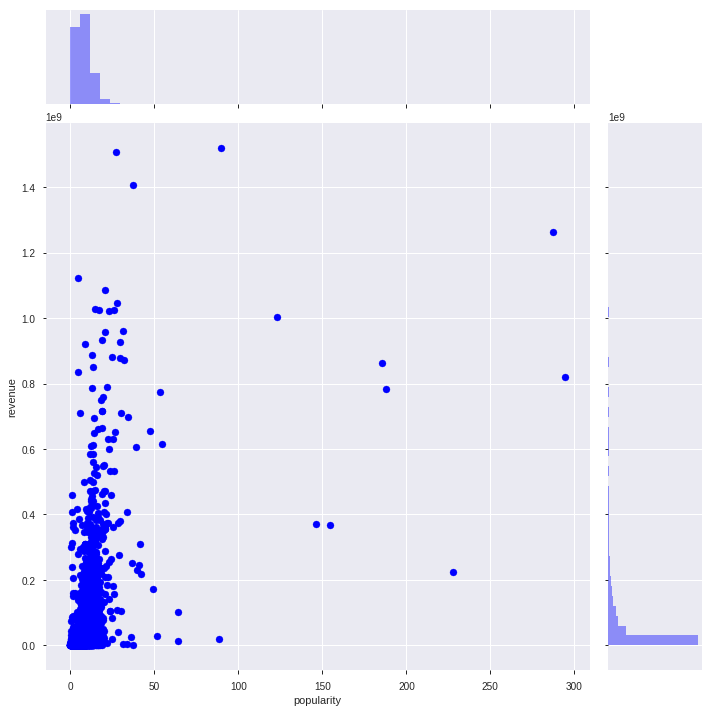

In [11]:
sns.jointplot(x="popularity", y="revenue", data=train, height=10, ratio=5, color="b")
plt.show()

__Runtime vs Revenue__

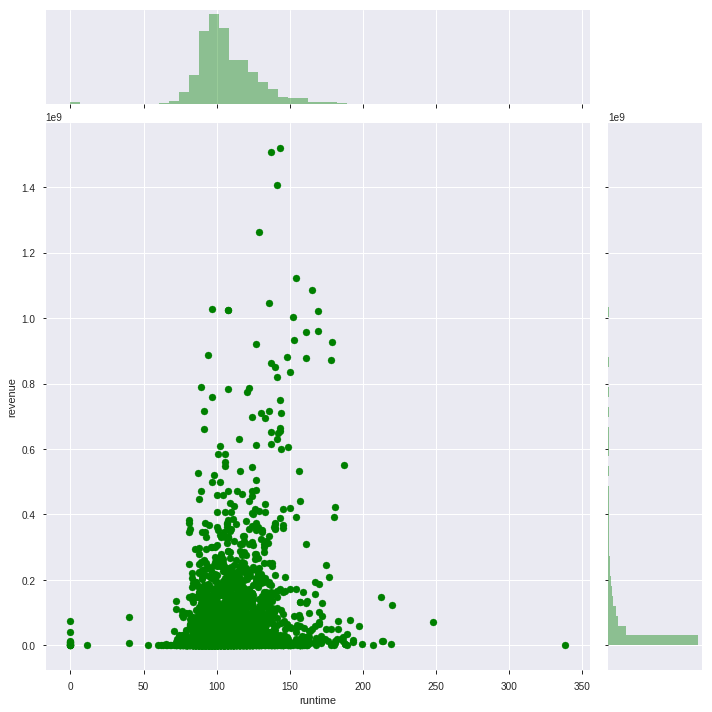

In [12]:
sns.jointplot(x="runtime", y="revenue", data=train, height=10, ratio=5, color="g")
plt.show()

__Revenue Distribution__

Majority of movies are near the zero line, 75% of them under 68 Million. So, we need to apply log scaling to make the data distribution conducive to analysis/modeling

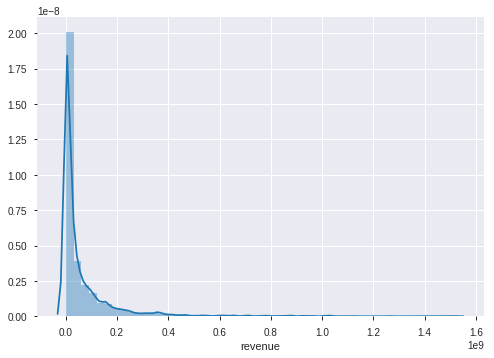

In [13]:
sns.distplot(train.revenue)

In [14]:
train.revenue.describe()

count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64

Apply log1p function to take care of any odd cases with 0 revenues breaking application of log

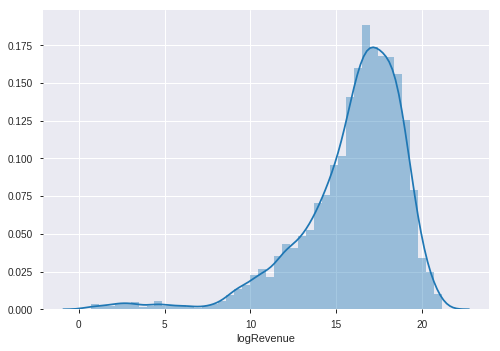

In [15]:
train['logRevenue'] = np.log1p(train['revenue'])
sns.distplot(train['logRevenue'])

### Release date exploration

In [16]:
train['release_date'].head()

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
Name: release_date, dtype: object

Since only last two digits of the year are provided, let us manipulate and get correct year

In [17]:
# Split release date to individual parts
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)


In [18]:
train['release_year'].max()

99

In [19]:
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100) , "release_year"] += 2000
train.loc[ (train['release_year'] > 19) & (train['release_year'] < 100) , "release_year"] += 1900

__Additional Features from Release Date__

* Day of the week of release
* quarter of release

In [20]:
# Make new features from date, day of week and quarter...
releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek
train['release_quarter'] = releaseDate.dt.quarter

__Plot Release Year Count__ - shows significant uptick of movie releases from 1980's onwards, makes sense as society becomes more affluent, with noticeable dips due to economical conditions. 

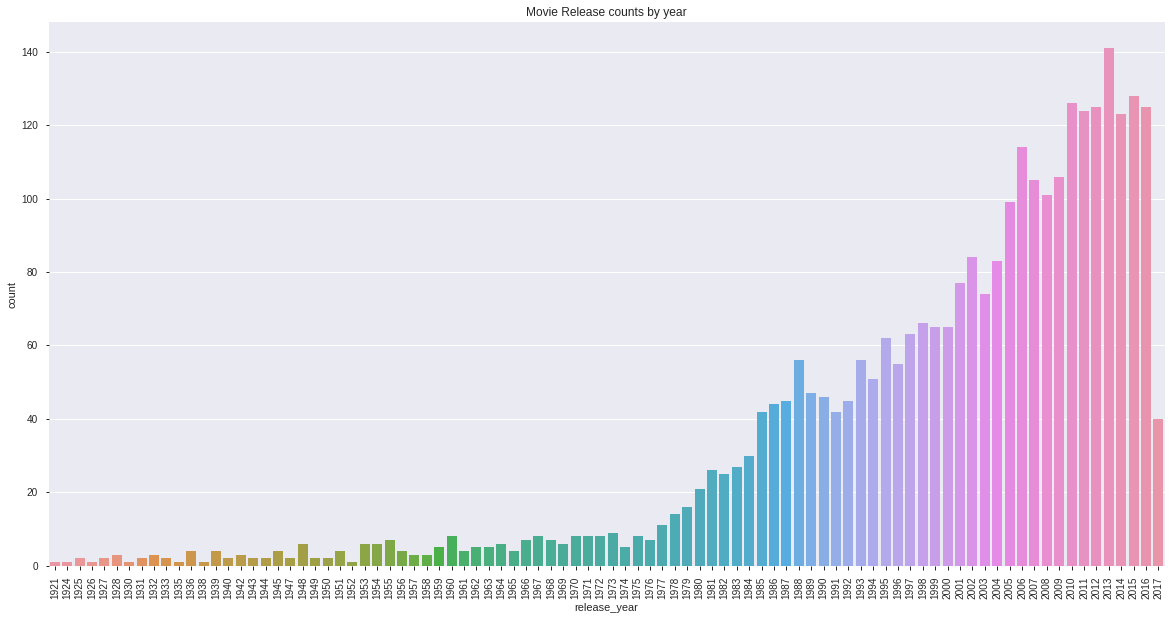

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(train['release_year'].sort_values())
plt.title("Movie Release counts by year")
loc, labels = plt.xticks()
plt.xticks(rotation=90)
plt.show()

__Plot Release Month Counts__ Shows month wise variations in release counts, interesting observation that late summer and early fall has maximum number of releases.

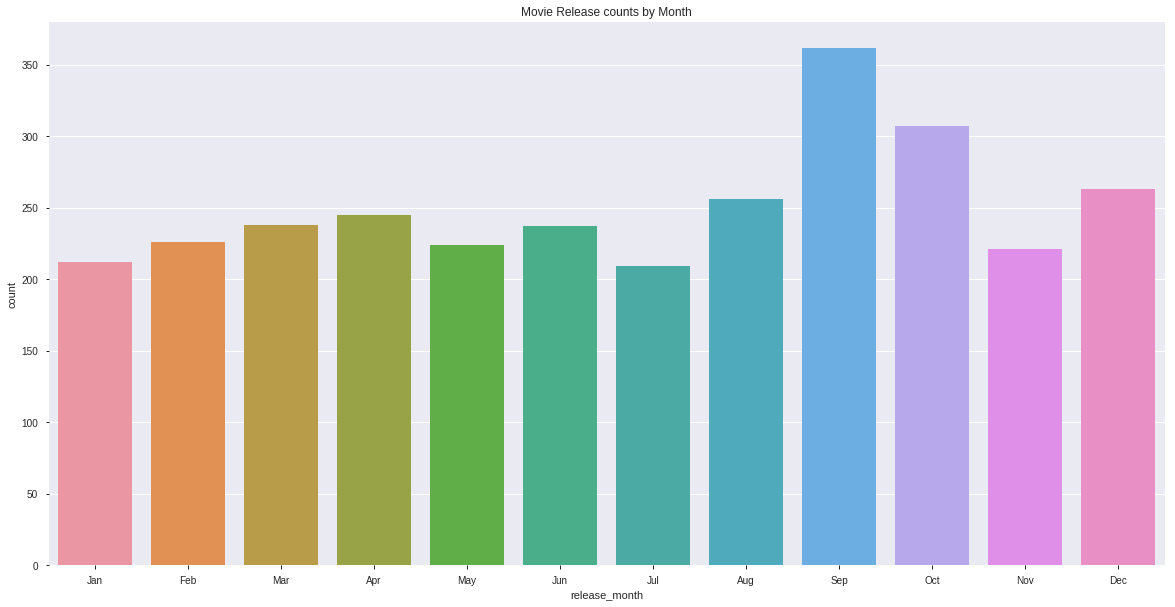

In [22]:
plt.figure(figsize=(20,10))
sns.countplot(train['release_month'].sort_values())
plt.title("Movie Release counts by Month")
loc, labels = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels)
plt.show()

__Plot Release Day Counts__ Mostly stable, First day of the month and middle of the month have many releases - Does it match with pay patterns of twice a month payments for salaried moviegoers? May be, but would be a tangent for problem at hand.

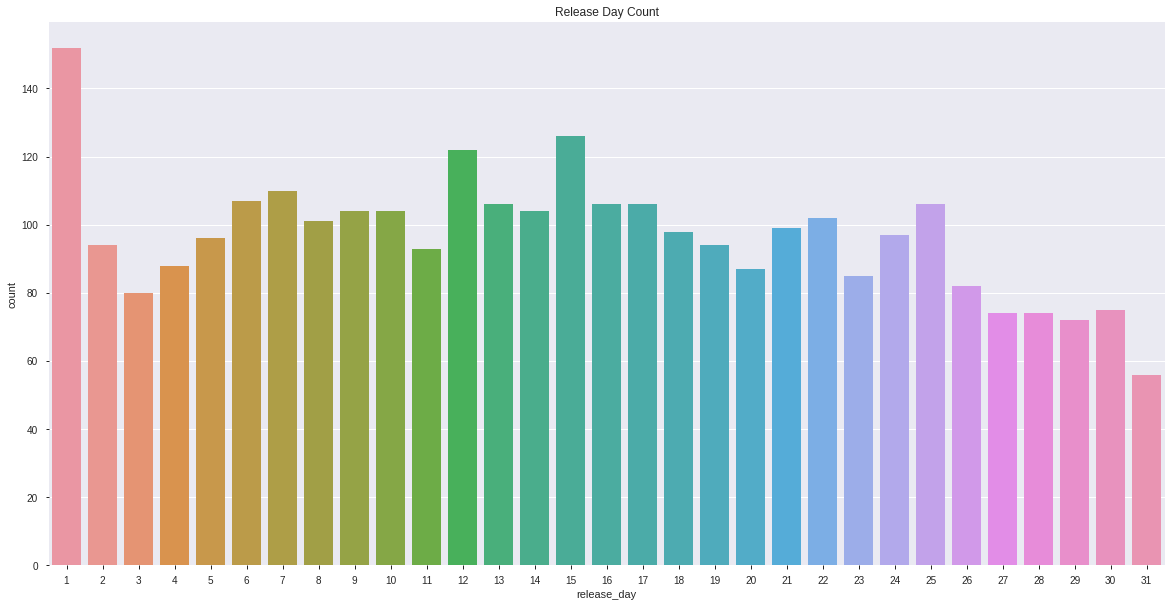

In [23]:
plt.figure(figsize=(20,10))
sns.countplot(train['release_day'].sort_values())
plt.title("Release Day Count")
plt.xticks()
plt.show()

__Plot Release Day of Week__ Perfect, matches with intuition here, majority of movies are released on Fridays' followed by Thursdays' as moviegoers are eager to spend sometime on their weekend for entertainment.

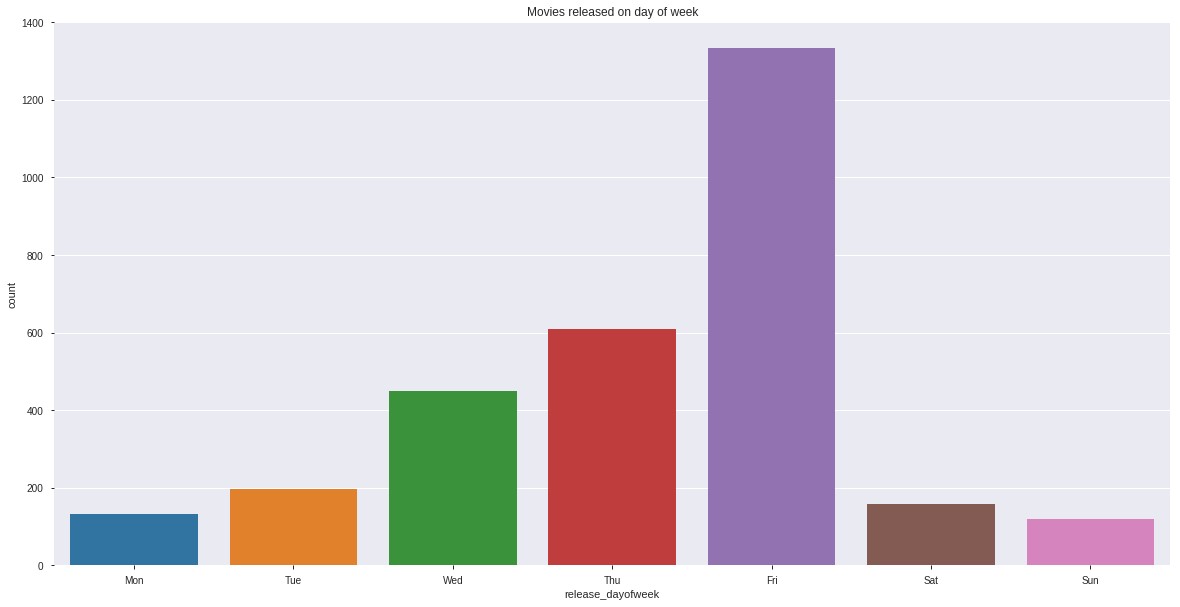

In [24]:
plt.figure(figsize=(20,10))
sns.countplot(train['release_dayofweek'].sort_values())
plt.title("Movies released on day of week")
loc, labels = plt.xticks()
loc, labels = loc, ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
plt.xticks(loc, labels)
plt.show()

__Plot Release quarter Counts__ No surprises here, matches with monthly trends, Summer and Fall have higher releases compared to other two quarters.

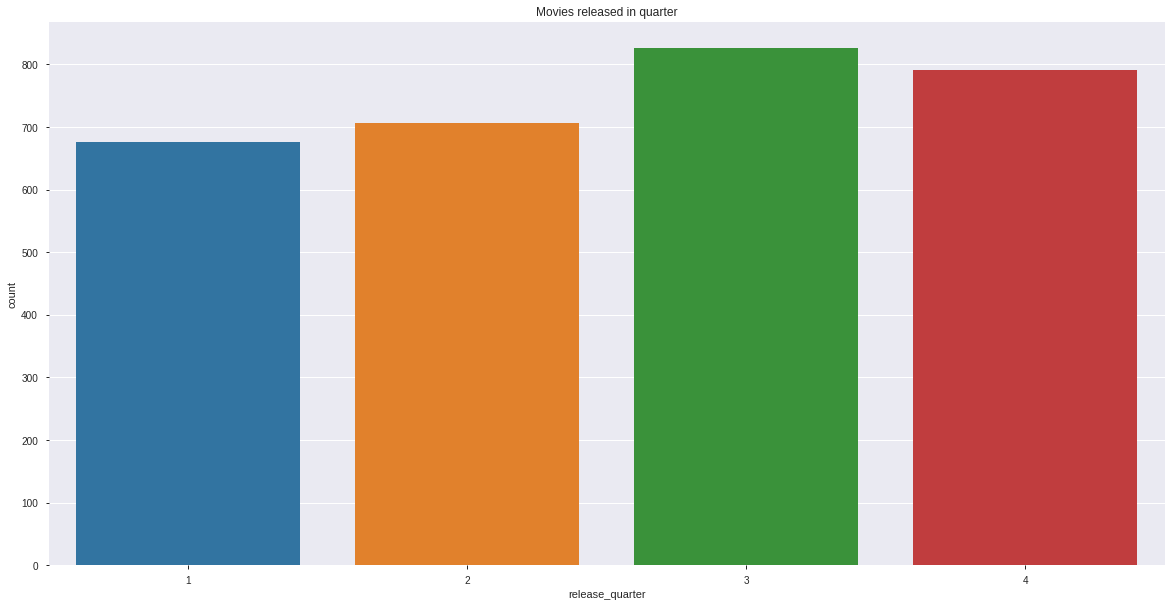

In [25]:
plt.figure(figsize=(20,10))
sns.countplot(train['release_quarter'].sort_values())
plt.title("Movies released in quarter")
plt.show()

__Plot Release Year vs Revenue__ Good, matches with intuition and upward trend with movie release counts from 80's following valleys due to economic fluctuations.

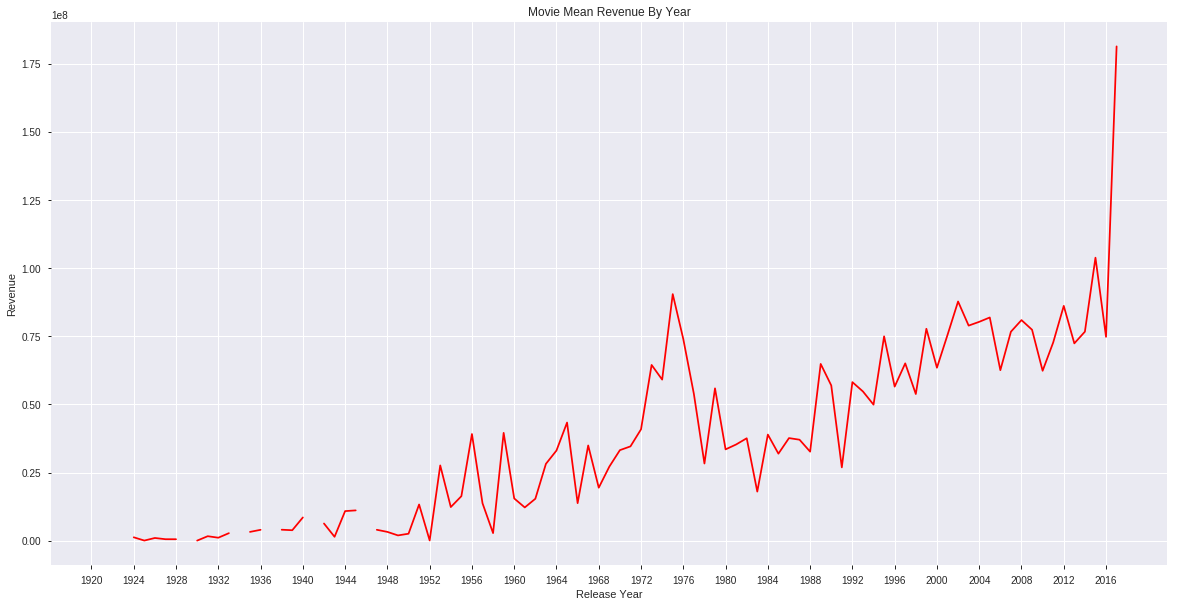

In [26]:
train['meanRevenueByYear'] = train.groupby("release_year")["revenue"].aggregate('mean')
train['meanRevenueByYear'].plot(figsize=(20,10),color="r")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year")
plt.show()



__Release Month vs Revenue Plot__ Interesting observation here, mean revenue peaks at June, and hits bottom during September (when maximum movies are released). Supply and demand?!

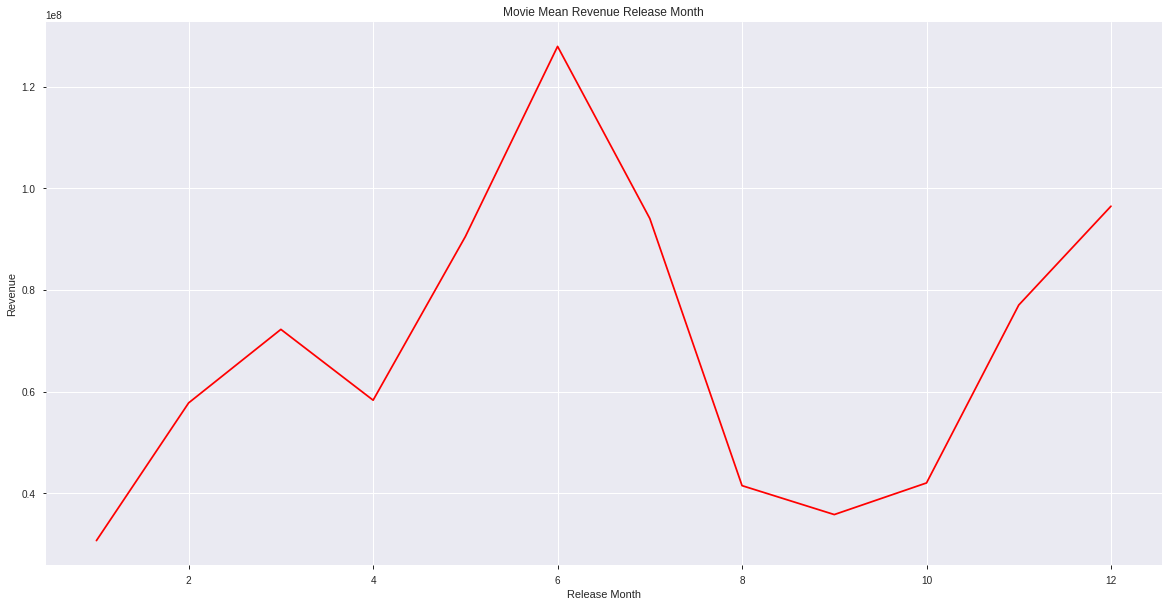

In [27]:
train['meanRevenueByMonth'] = train.groupby("release_month")["revenue"].aggregate('mean')
train['meanRevenueByMonth'].plot(figsize=(20,10),color="r")
plt.xlabel("Release Month")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue Release Month")
plt.show()

__Release Day of Week vs Revenue__ Graph indicates that Wednesday releases have peak revenue compared to Friday and Sunday. However many movies are released on Friday followed by Thursday. This is not significant in our analysis as it would suggest.

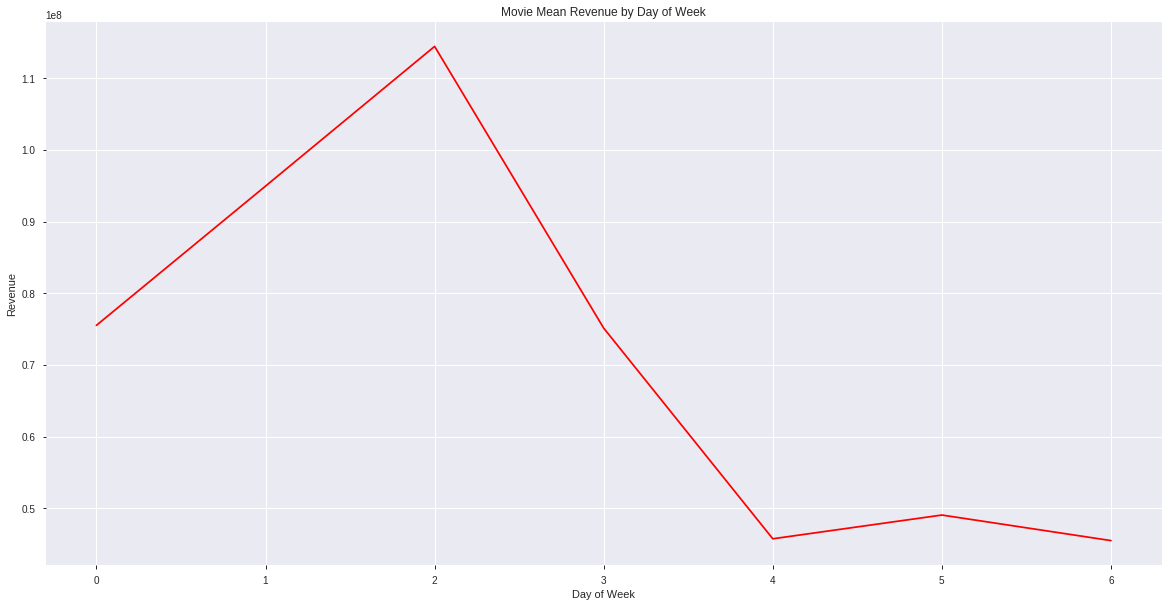

In [28]:
train['meanRevenueByDayOfWeek'] = train.groupby("release_dayofweek")["revenue"].aggregate('mean')
train['meanRevenueByDayOfWeek'].plot(figsize=(20,10),color="r")
plt.xlabel("Day of Week")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue by Day of Week")
plt.show()



__Movie Mean Runtime by year__ Visualizing average runtime of movies, we can see a trend movies were very long in early phases averaging 150 minutes, They hit a minimum during great recession, were bouncing around little less than 2 hour mark. It is interesting to mote that the average peaked just after II world war and again after Vietnam war? I think it is tangent exploring those aspects, it is more or less stable around 2 hours mark, let us move on...

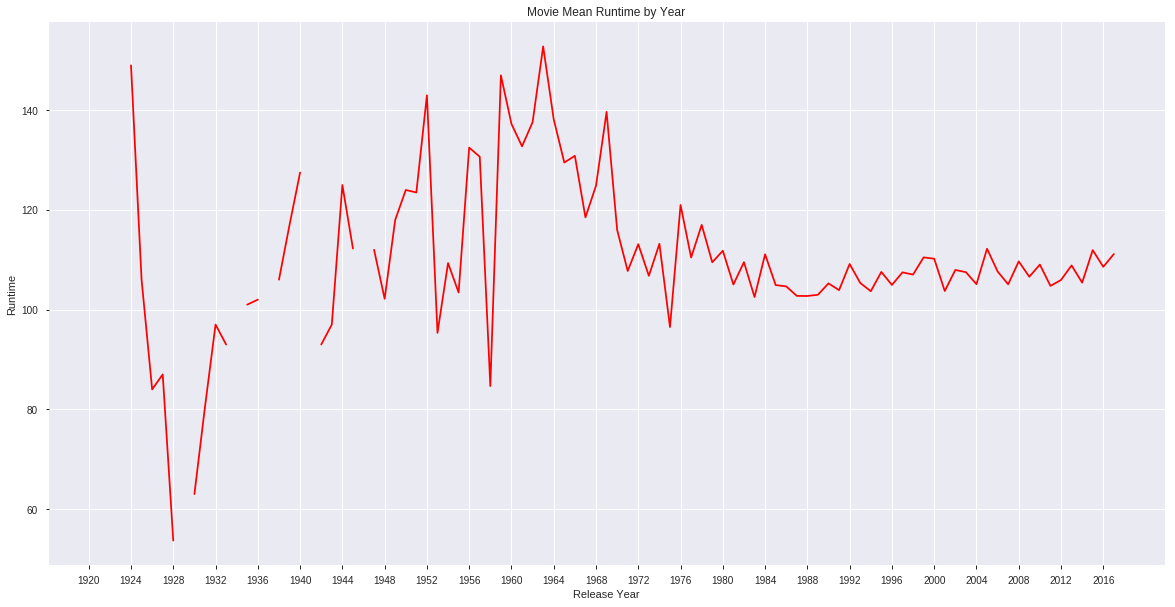

In [29]:
train['meanruntimeByYear'] = train.groupby("release_year")["runtime"].aggregate('mean')
train['meanruntimeByYear'].plot(figsize=(20,10),color="r")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Runtime")
plt.title("Movie Mean Runtime by Year")
plt.show()

__Mean popularity by Year__ General uptick in movie popularity, no surprises, except a huge rise in 2016

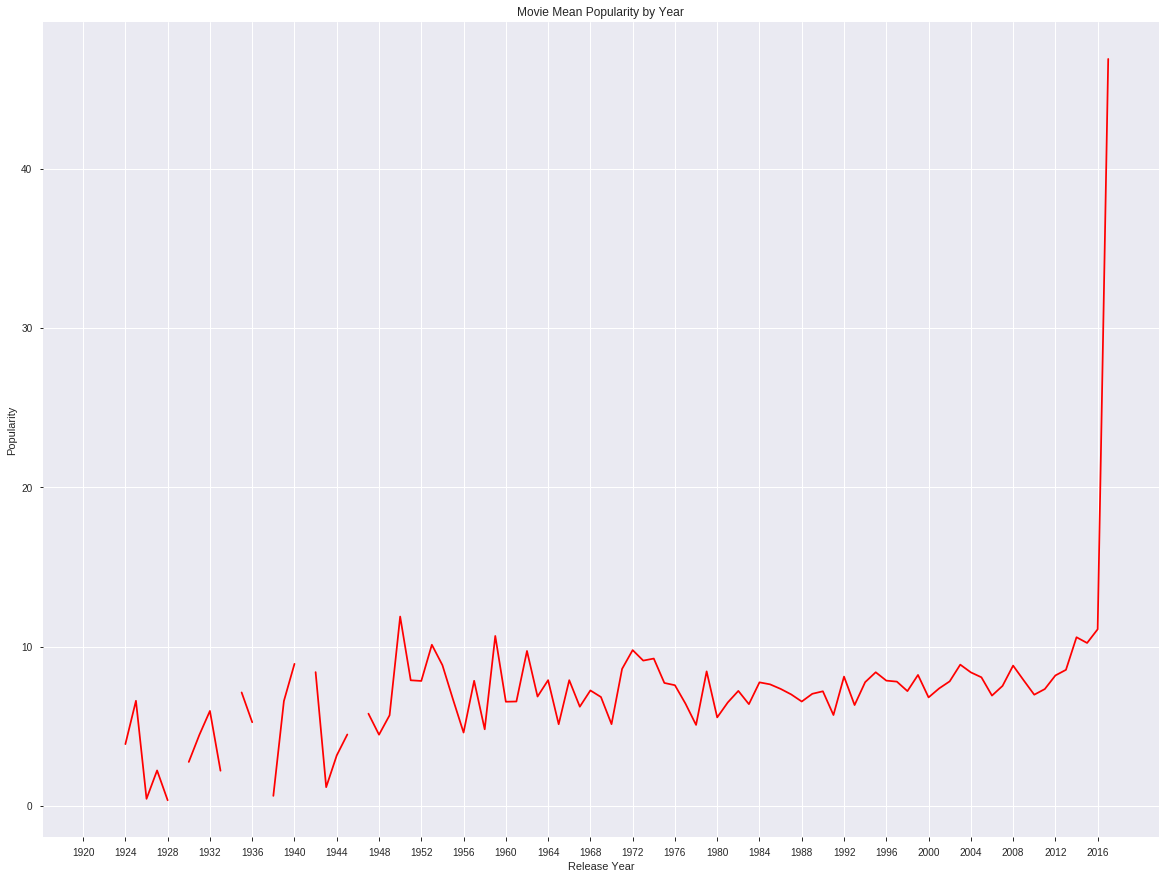

In [30]:
train['meanPopularityByYear'] = train.groupby("release_year")["popularity"].aggregate('mean')
train['meanPopularityByYear'].plot(figsize=(20,15),color="r")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Popularity")
plt.title("Movie Mean Popularity by Year")
plt.show()

__Movie Mean Budget by Year__ General uptick in average budget spent on movies, matches with intuition on increased number of movies made over years. Matches with economic trends as well.

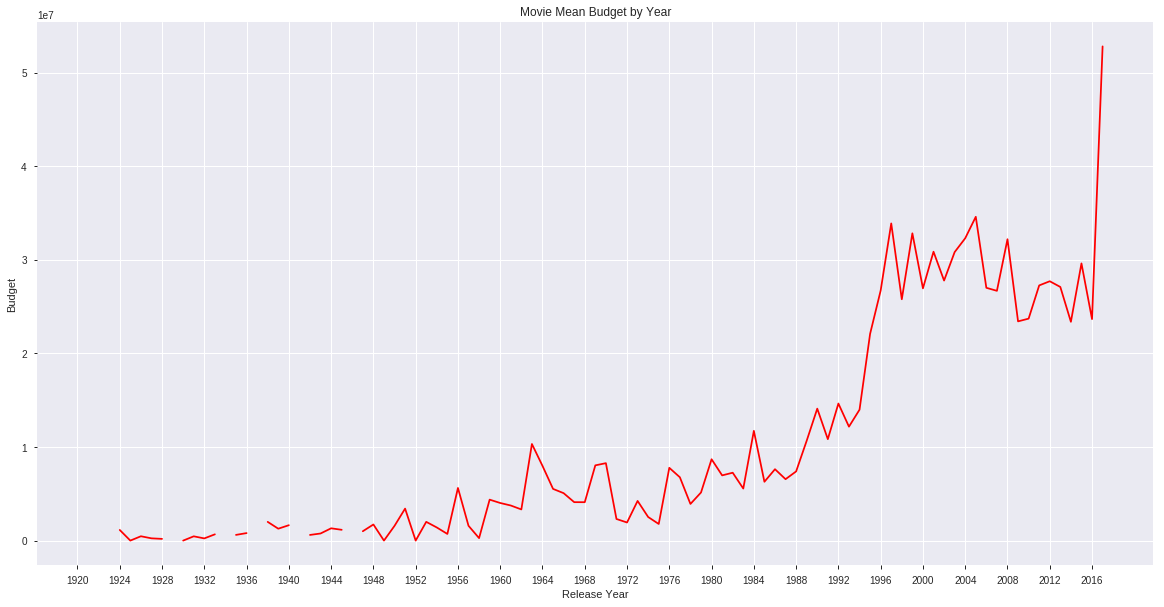

In [31]:
train['meanBudgetByYear'] = train.groupby("release_year")["budget"].aggregate('mean')
train['meanBudgetByYear'].plot(figsize=(20,10),color="r")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Budget")
plt.title("Movie Mean Budget by Year")
plt.show()

__Count Genres in training dataset__ No surprises here, moviegoers go to movies to experience drama, data shows at least half of the movies are "Drama" genre. Followed by one third of them in "Comedy", one fourth in "Thriller" and "Action"

In [32]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

train = train
train['genres'] = train['genres'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
genres = train.genres.str.get_dummies(sep=',')
train = pd.concat([train, genres], axis=1, sort=False)
for col in genres:
    print(col, "Genres Movie : ",  genres[col].sum())

Action Genres Movie :  741
Adventure Genres Movie :  439
Animation Genres Movie :  141
Comedy Genres Movie :  1028
Crime Genres Movie :  469
Documentary Genres Movie :  87
Drama Genres Movie :  1531
Family Genres Movie :  260
Fantasy Genres Movie :  232
Foreign Genres Movie :  31
History Genres Movie :  132
Horror Genres Movie :  301
Music Genres Movie :  100
Mystery Genres Movie :  225
Romance Genres Movie :  571
Science Fiction Genres Movie :  290
TV Movie Genres Movie :  1
Thriller Genres Movie :  789
War Genres Movie :  100
Western Genres Movie :  43


__Count Genres in test dataset__ A quick check on test dataset to see if there are any oddities on Genres column, matches with overall trends, no issues here.

In [33]:
test = test
test['genres'] = test['genres'].map(lambda x: sorted([d['name'] for d in get_dictionary(x)])).map(lambda x: ','.join(map(str, x)))
genres = test.genres.str.get_dummies(sep=',')
test = pd.concat([test, genres], axis=1, sort=False)
for col in genres:
    print(col, "Genres Movie : ",  genres[col].sum())

Action Genres Movie :  994
Adventure Genres Movie :  677
Animation Genres Movie :  241
Comedy Genres Movie :  1577
Crime Genres Movie :  615
Documentary Genres Movie :  134
Drama Genres Movie :  2145
Family Genres Movie :  415
Fantasy Genres Movie :  396
Foreign Genres Movie :  53
History Genres Movie :  163
Horror Genres Movie :  434
Music Genres Movie :  167
Mystery Genres Movie :  325
Romance Genres Movie :  864
Science Fiction Genres Movie :  454
Thriller Genres Movie :  1080
War Genres Movie :  143
Western Genres Movie :  74


__Original Language Counts__ Most movies, > 80% are __English__ probably due to popularity of English language and popularity of Hollywood movies, would be concerning to generalize the analysis and model we build to worldwide predictions, especially when movies are becoming popular worldwide and other languages are catching up quickly.

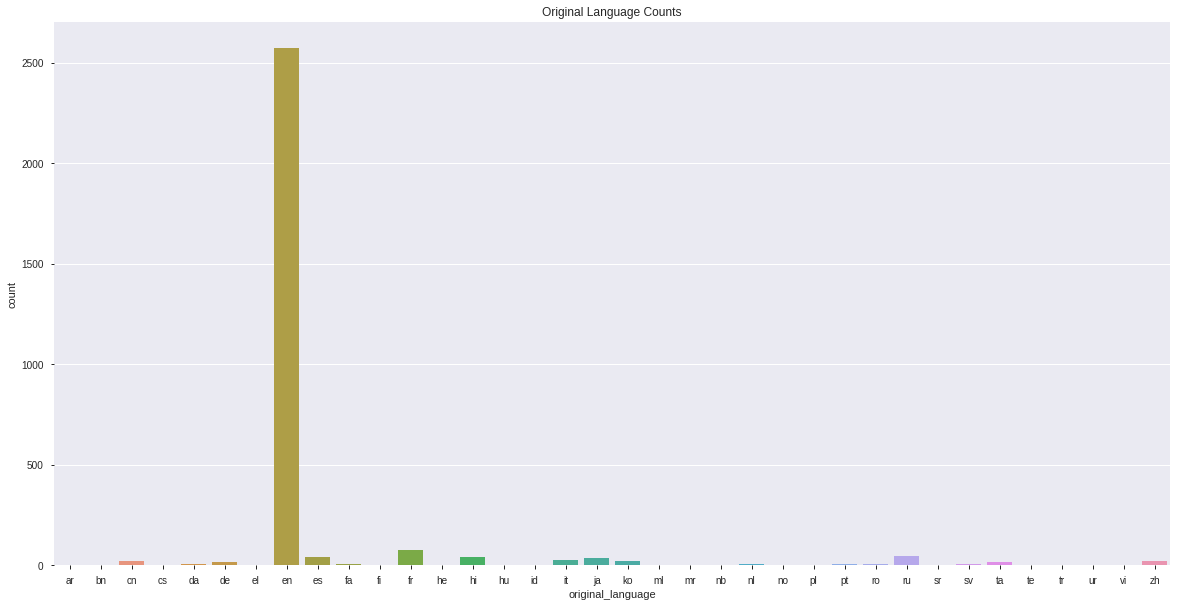

In [34]:
plt.figure(figsize=(20,10))
sns.countplot(train['original_language'].sort_values())
plt.title("Original Language Counts")
plt.show()

__Status Analysis__ A quick peak at counts of "status" of movies

In [35]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

Do we have revenue for 4 movies? how is it possible for movies not released yet? Something to consider while doing feature engineering on how to handle these exceptions.

In [36]:
train.loc[train['status'] == "Rumored"][['status','revenue']]

status   revenue
609   Rumored    273644
1007  Rumored        60
1216  Rumored  13418091
1618  Rumored    229000

How about in test dataset? 4389 movies released, 7 are yet to be released.

In [37]:
test['status'].value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

___Homepage analysis__. How many movies have a homepage? Could be used as a binary feature.

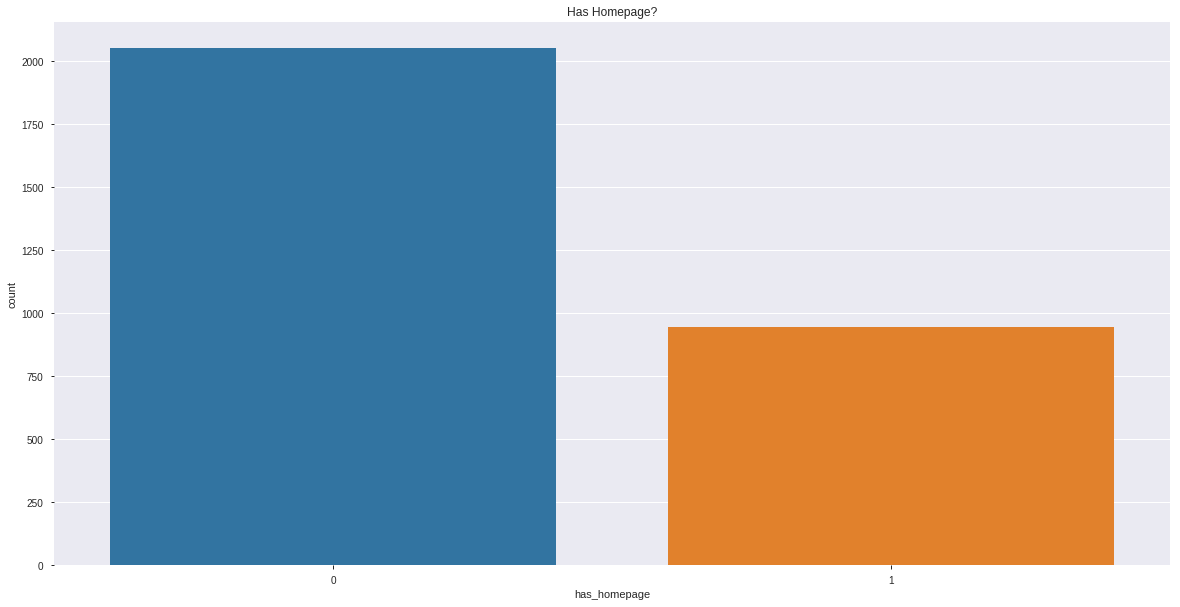

In [38]:
train['has_homepage'] = 1
train.loc[pd.isnull(train['homepage']) ,"has_homepage"] = 0
plt.figure(figsize=(20,10))
sns.countplot(train['has_homepage'].sort_values())
plt.title("Has Homepage?")
plt.show()



Correlation between __has_homepage and revenue__ From visualization, we can infer that movies with home page generally have higher revenues, they are more popular.

Text(0.5, 1.0, 'Revenue of movies with/wihtout homepage')

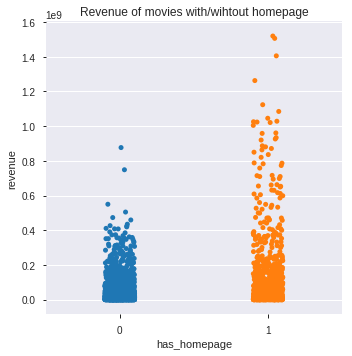

In [39]:
sns.catplot(x="has_homepage", y="revenue", data=train)
plt.title("Revenue of movies with/wihtout homepage")

Does Movie has __tagline__? How does it affect revenue? Analysis indicates movies with __Tagline__ are more popular and command more revenues.

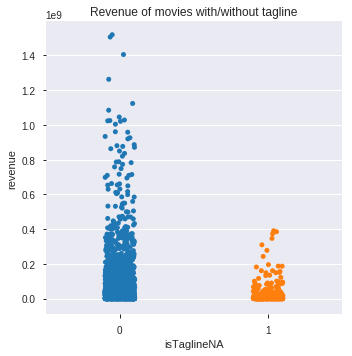

In [40]:
train['isTaglineNA'] = 0
train.loc[pd.isnull(train['tagline']) ,"isTaglineNA"] = 1
sns.catplot(x="isTaglineNA", y="revenue", data=train)
plt.title('Revenue of movies with/without tagline');

Is __movie title__ different? Some movies have same titles, analyzing effect of title being same and different with categorical plot and impact on revenue, we can conclude that if title is same movies command more revenue, probably effect of previous title success carrying over to new release with same title.

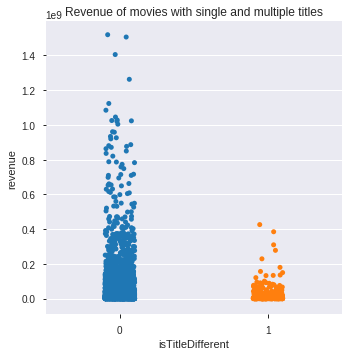

In [41]:
train['isTitleDifferent'] = 1
train.loc[ train['original_title'] == train['title'] ,"isTitleDifferent"] = 0 
sns.catplot(x="isTitleDifferent", y="revenue", data=train)
plt.title('Revenue of movies with single and multiple titles');

What is the effect of __orginal language__ if it __English__ on revenue? Agrees with analysis of __Original Language__ Most of our training dataset is English movies.

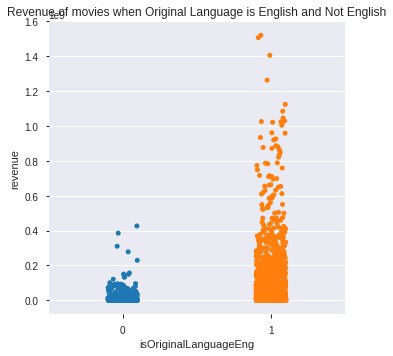

In [42]:
train['isOriginalLanguageEng'] = 0 
train.loc[train['original_language'] == "en" ,"isOriginalLanguageEng"] = 1
sns.catplot(x="isOriginalLanguageEng", y="revenue", data=train)
plt.title('Revenue of movies when Original Language is English and Not English');

### Additional features
We do have additional dataset with __rating__ and __total votes__ for movies. It would be interesting to augment given dataset with additional features, gives me an opportunity to explore joins, missing records due to joins, impute or decide on what to do with missing values. Keep building skills!

In [43]:
trainAdditionalFeatures = pd.read_csv('data/TrainAdditionalFeatures.csv')
testAdditionalFeatures = pd.read_csv('data/TestAdditionalFeatures.csv')

train = pd.merge(train, trainAdditionalFeatures, how='left', on=['imdb_id'])
test = pd.merge(test, testAdditionalFeatures, how='left', on=['imdb_id'])


In [44]:
trainAdditionalFeatures.head()

imdb_id  popularity2  rating  totalVotes
0  tt0169547       16.217     8.0      6016.0
1  tt0119116       26.326     7.4      5862.0
2  tt0325980       28.244     7.7     11546.0
3  tt0266697       18.202     7.9      8638.0
4  tt0418763        9.653     6.6      1201.0

__Missing value analysis__ in additional datasets

In [45]:
train['rating'].isna().sum()

118

In [46]:
train['totalVotes'].isna().sum()

118

In [47]:
test['rating'].isna().sum()

179

In [48]:
test['totalVotes'].isna().sum()

179

Quite a few additional features have missing records. So, let us fill them with some __reasonable defaults__, 5 votes and a rating of 1.5, cautious defaulting to low values.

In [49]:
train['rating'] = train['rating'].fillna(1.5)
train['totalVotes'] = train['totalVotes'].fillna(5)

test['rating'] = test['rating'].fillna(1.5)
test['totalVotes'] = test['totalVotes'].fillna(5)

Training set __Rating Visualization__ Apart from the defaulting for missing values, data follows roughly normal distribution, great!

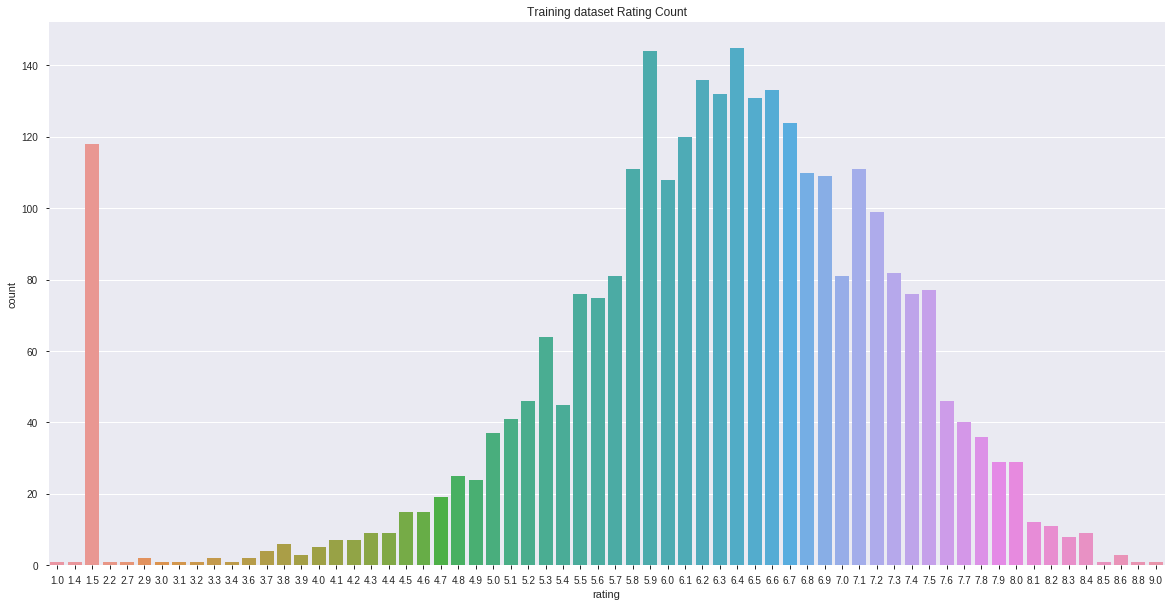

In [50]:
plt.figure(figsize=(20,10))
sns.countplot(train['rating'].sort_values())
plt.title("Training dataset Rating Count")
plt.show()

__Testing__ dataset __rating visualization__ Roughly follows training dataset trends, no concerns on using this as feature.

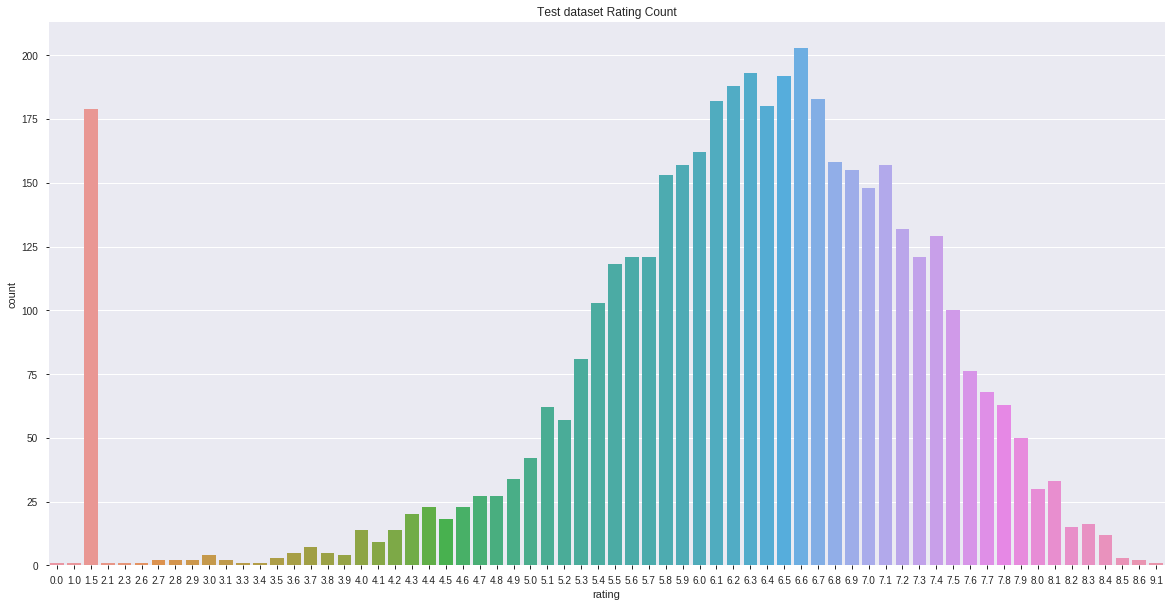

In [51]:
plt.figure(figsize=(20,10))
sns.countplot(test['rating'].sort_values())
plt.title("Test dataset Rating Count")
plt.show()

Let us explore significance of __rating__ on __Mean Revenue__ in __Training__ dataset. A rating of 6 has peak revenue, followed by 7 and 8, this would be good feature to predict on!

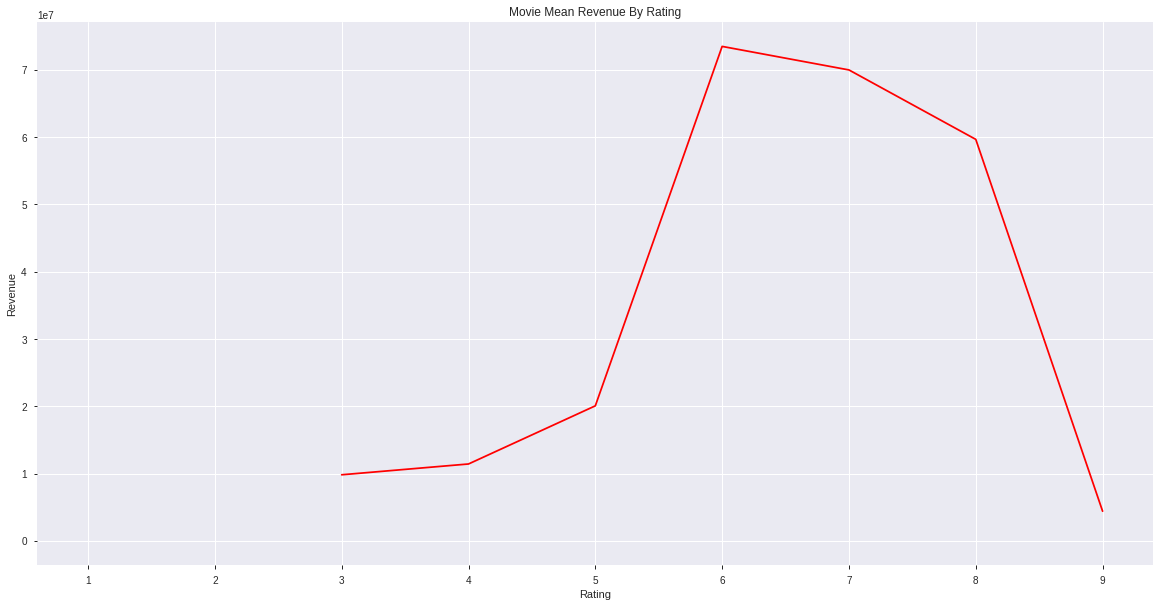

In [52]:
train['meanRevenueByRating'] = train.groupby("rating")["revenue"].aggregate('mean')
train['meanRevenueByRating'].plot(figsize=(20,10),color="r")
plt.xlabel("Rating")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Rating")
plt.show()

__Mean Revenue vs Total Votes__ visualization. Movies with votes in the range of 900 to 1600 tend to command good revenues

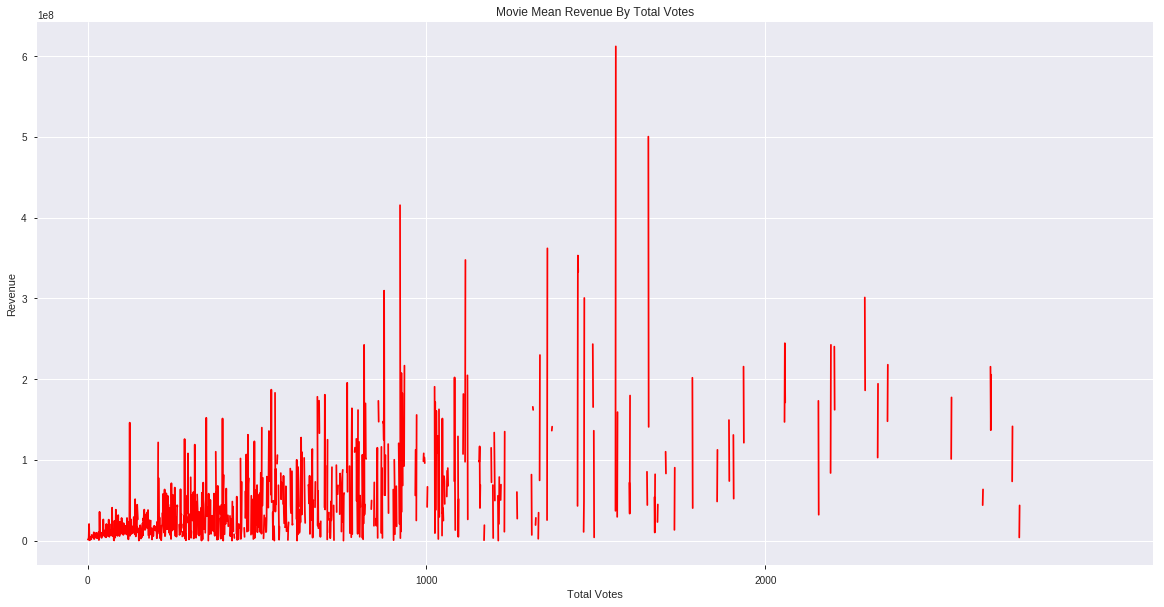

In [53]:
train['meanRevenueByTotalVotes'] = train.groupby("totalVotes")["revenue"].aggregate('mean')
train['meanRevenueByTotalVotes'].plot(figsize=(20,10),color="r")
plt.xticks(np.arange(0,3000,1000))
plt.xlabel("Total Votes")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Total Votes")
plt.show()

trends of __total votes over release year__ follow overall uptick with movie releases over year, gives confidence we could use this as predictor feature.

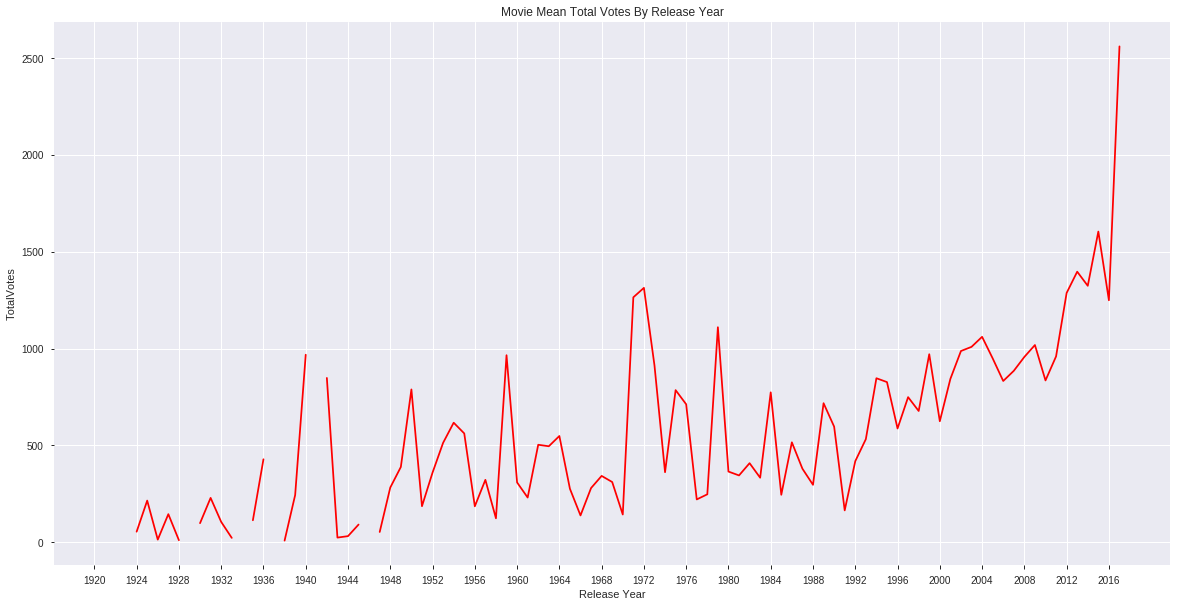

In [54]:
train['meantotalVotesByYear'] = train.groupby("release_year")["totalVotes"].aggregate('mean')
train['meantotalVotesByYear'].plot(figsize=(20,10),color="r")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("TotalVotes")
plt.title("Movie Mean Total Votes By Release Year")
plt.show()

__Total Votes vs Rating__ Visualization to analyze how they could potentially be interrelated.

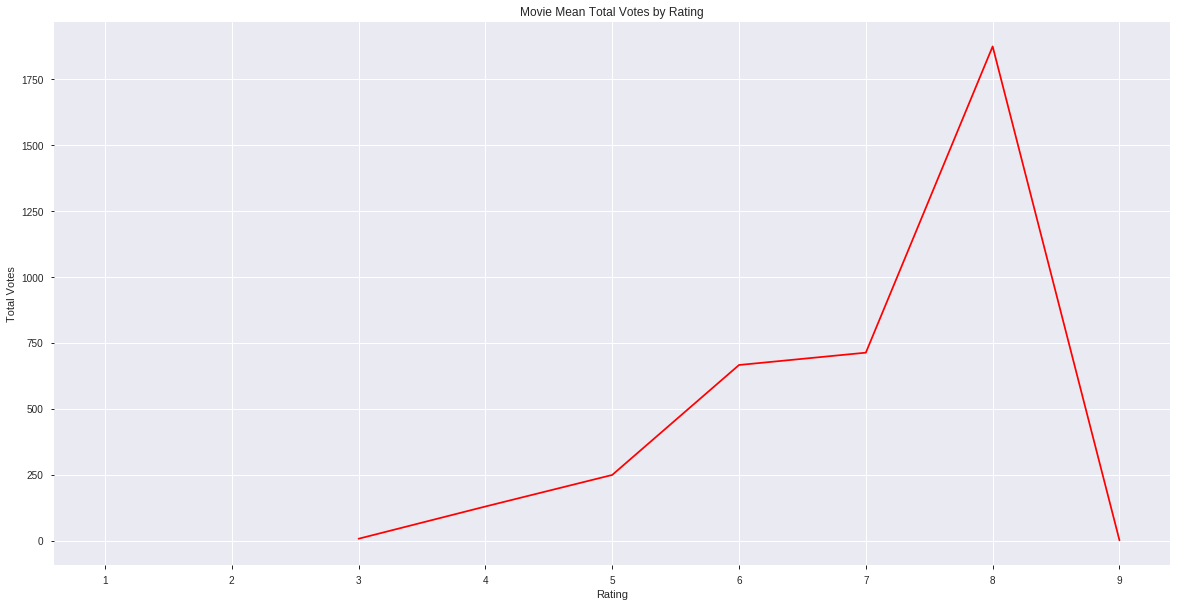

In [55]:
train['meanTotalVotesByRating'] = train.groupby("rating")["totalVotes"].aggregate('mean')
train['meanTotalVotesByRating'].plot(figsize=(20,10),color="r")
plt.xlabel("Rating")
plt.ylabel("Total Votes")
plt.title("Movie Mean Total Votes by Rating")
plt.show()

## Word Cloud Visualization - Original Title

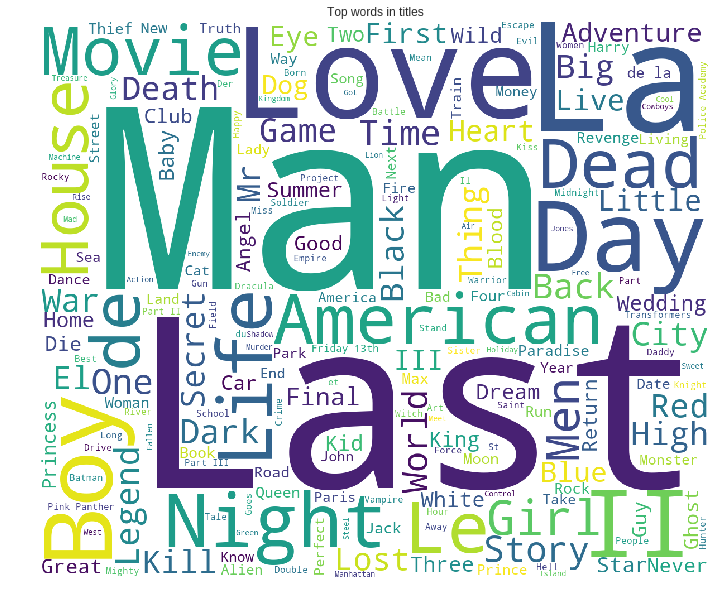

In [56]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()


## Word Cloud Visualization - Overview

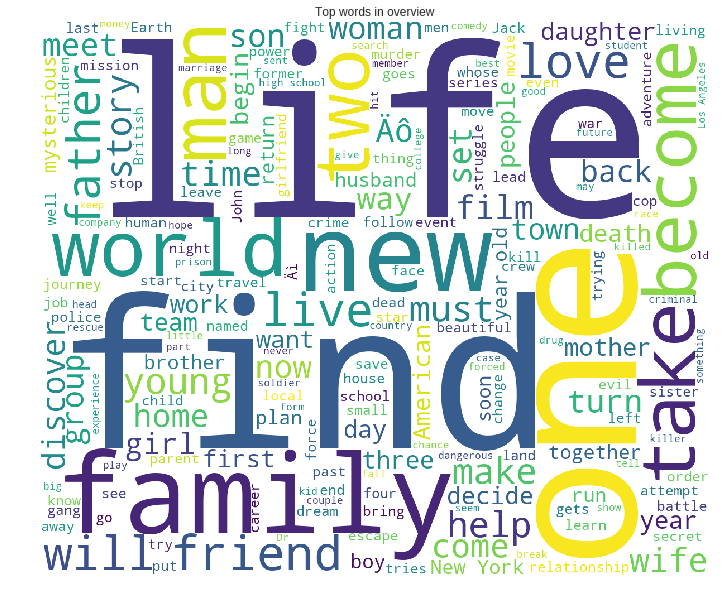

In [57]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

## Word Cloud Visualization - Tagline

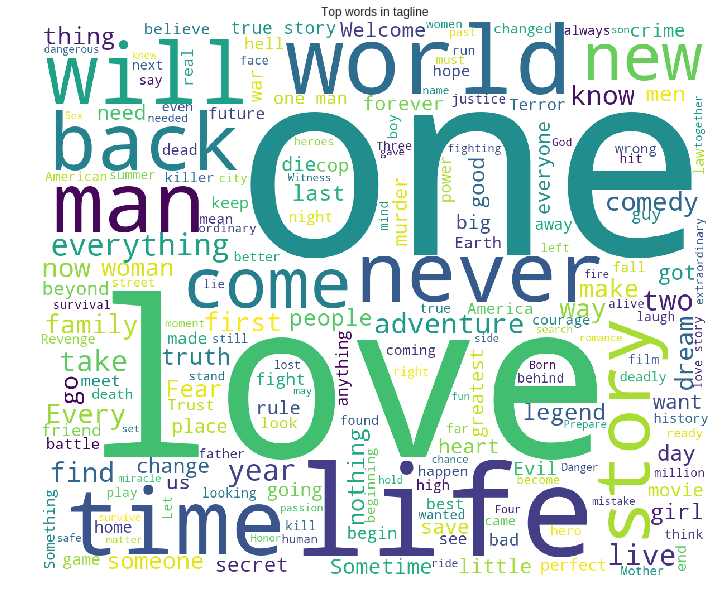

In [58]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()



Let us do a __Heat Map__ for correlation visualizations

As expected, __total votes and revenue__ show __very high correlation at *0.77*__, as highly voted movies perform well at box office, followed by __budget and revenue at *0.75*__, which makes sense as well as highly popular movies which collect large revenues typically have huge budgets. __Popularity__ takes up next spot at __*0.46*__ correlation to revenue, __runtime at *0.22*__. It is surprising to see __rating is only at *0.17*__. Release year and release day of week and release month show very weak to very weak negative correlation.

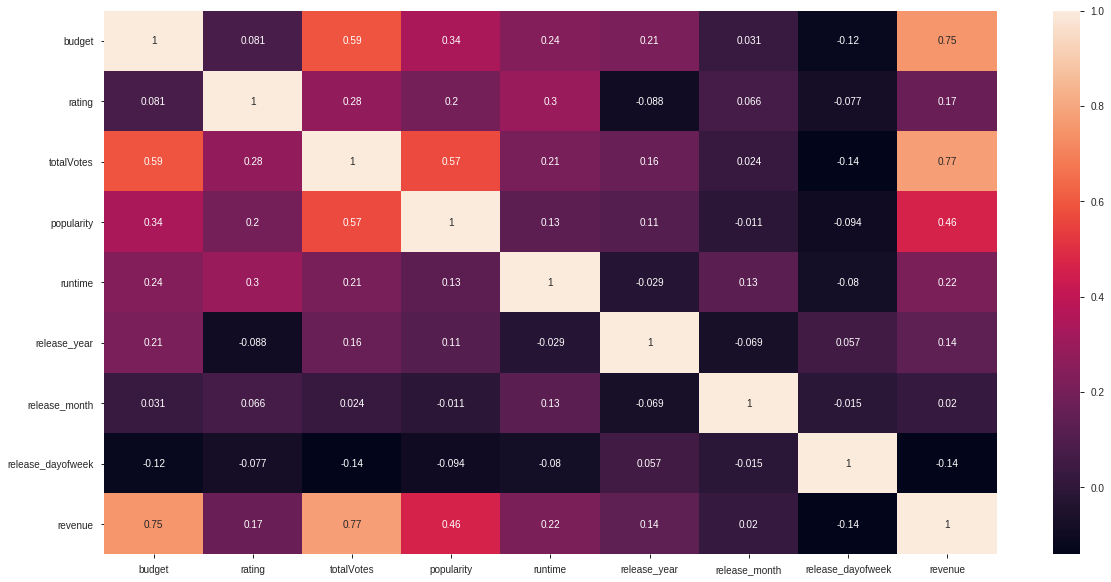

In [59]:
train_viz = train[['budget','rating','totalVotes','popularity','runtime','release_year','release_month','release_dayofweek','revenue']]
f,ax = plt.subplots(figsize=(20, 10))
sns.heatmap(train_viz.corr(), annot=True)
plt.show()

With thorough understanding of data used, including additional features, let us tackle feature engineering. We could do this modern ML Engineering way with breaking down into modules, building tests etc., however, I chose to do this within notebook to stay focused on project and finishing it on time, instead of getting side tracked with beautification and production grade hardening of ML Feature engineering pipeline.

## Feature Engineering

Putting together various data exploration activities, transformation snippets, handing JSON, modularizing where possible, wrote a __data_pref__ function.

In [60]:
def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

def get_json_dict(df) :
    global json_cols
    result = dict()
    for e_col in json_cols :
        d = dict()
        rows = df[e_col].values
        for row in rows :
            if row is None : continue
            for i in row :
                if i['name'] not in d :
                    d[i['name']] = 0
                d[i['name']] += 1
        result[e_col] = d
    return result

def data_prep(df):
    
    # release_date handling, splitting and taking care of double digit years.
    df[['release_month','release_day','release_year']]=df['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    df['release_year'] = df['release_year']
    df.loc[ (df['release_year'] <= 19) & (df['release_year'] < 100), "release_year"] += 2000
    df.loc[ (df['release_year'] > 19) & (df['release_year'] < 100), "release_year"] += 1900
    releaseDate = pd.to_datetime(df['release_date']) 
    df['release_dayofweek'] = releaseDate.dt.dayofweek 
    df['release_quarter'] = releaseDate.dt.quarter     
    
    rating_na = df.groupby(["release_year","original_language"])['rating'].mean().reset_index()
    df[df.rating.isna()]['rating'] = df.merge(rating_na, how = 'left' ,on = ["release_year","original_language"])
    vote_count_na = df.groupby(["release_year","original_language"])['totalVotes'].mean().reset_index()
    df[df.totalVotes.isna()]['totalVotes'] = df.merge(vote_count_na, how = 'left' ,on = ["release_year","original_language"])
    df['rating'] = df['rating'].fillna(1.5)
    df.loc[ (df['rating'] == 0 ), "rating"] += 1.5
    df['totalVotes'] = df['totalVotes'].fillna(5)
    df.loc[ (df['totalVotes'] == 0 ), "totalVotes"] += 1.5
    df['weightedRating'] = ( df['rating']*df['totalVotes'] + 6.367 * 1000 ) / ( df['totalVotes'] + 1000 )


    # Budget amount... adjust for infation and take log, to adjust for skewness
    df['originalBudget'] = df['budget']
    df['inflationBudget'] = df['budget'] + df['budget']*2.1/100*(2018-df['release_year']) #Inflation assuming simplistic 2.1% per year
    df['budget'] = np.log1p(df['inflationBudget']) 
    
    # Gender aggregations
    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
    
    df.loc[ (df['runtime'] == 0 ), "runtime"] += df['runtime'].mean()  
    
    df['_collection_name'] = df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    le = LabelEncoder()
    le.fit(list(df['_collection_name'].fillna('')))
    df['_collection_name'] = le.transform(df['_collection_name'].fillna('').astype(str))
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)
        
    df['_popularity_mean_year'] = df['popularity'] / df.groupby("release_year")["popularity"].transform('mean')
    
    df['_budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']

    df['_popularity_totalVotes_ratio'] = df['totalVotes']/df['popularity']
    df['_rating_popularity_ratio'] = df['rating']/df['popularity']
    df['_rating_totalVotes_ratio'] = df['totalVotes']/df['rating']
    df['_totalVotes_releaseYear_ratio'] = df['totalVotes']/df['release_year']
    df['_budget_rating_ratio'] = df['budget']/df['rating']
    df['_runtime_rating_ratio'] = df['runtime']/df['rating']
    df['_budget_totalVotes_ratio'] = df['budget']/df['totalVotes']
    
    # homepage - check for missing values
    df['has_homepage'] = 1
    df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 0
    
    # belongs to collection - check for missingvalues
    df['isbelongs_to_collectionNA'] = 0
    df.loc[pd.isnull(df['belongs_to_collection']) ,"isbelongs_to_collectionNA"] = 1
    
    # Tagline - check for missing values
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

    # Flag for original English language
    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'] == "en" ,"isOriginalLanguageEng"] = 1
    
    # Flag for title change betwee original and current title
    df['isTitleDifferent'] = 1
    df.loc[ df['original_title'] == df['title'] ,"isTitleDifferent"] = 0 

    # Flag for movie release status
    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 

    # extract collection id from belongs_to_collection
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
    
    # get counts of letters/words and similar conversions
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len()
    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()  
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))
    
    # get aggregates by release year, ratings vs votes
    df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')
    df['meanPopularityByYear'] = df.groupby("release_year")["popularity"].aggregate('mean')
    df['meanBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('mean')
    df['meantotalVotesByYear'] = df.groupby("release_year")["totalVotes"].aggregate('mean')
    df['meanTotalVotesByRating'] = df.groupby("rating")["totalVotes"].aggregate('mean')
    df['medianBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('median')

    for col in ['genres', 'production_countries', 'spoken_languages', 'production_companies']:
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
    df.drop(['genres_etc'], axis = 1, inplace = True)
    
    df = df.drop(['id', 'revenue','belongs_to_collection','genres','homepage','imdb_id','overview','runtime'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id'
    ],axis=1)
    
    df.fillna(value=0.0, inplace = True)

    return df

### Read datasets, including (additional features)

In [61]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')


test['revenue'] = np.nan

train = pd.merge(train, pd.read_csv('data/TrainAdditionalFeatures.csv'), how='left', on=['imdb_id'])
test = pd.merge(test, pd.read_csv('data/TestAdditionalFeatures.csv'), how='left', on=['imdb_id'])

Quick sanity check on columns read and shape of dataframes

In [62]:
print(train.columns)
print(train.shape)
print(test.columns)
print(test.shape)

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'popularity2', 'rating', 'totalVotes'],
      dtype='object')
(3000, 26)
Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'popularity2', 'rating', 'totalVotes'],
      dtype='object')
(4398, 26)


### Data pre-processing
Handling JSON expansions, dropping low frequency values to optimize feature matrix.

In [63]:
train['revenue']= np.log1p(train['revenue'])
y = train['revenue'].values


json_cols = ['genres', 'belongs_to_collection', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

for col in tqdm(json_cols) :
    train[col] = train[col].apply(lambda x : get_dictionary(x))
    test[col] = test[col].apply(lambda x : get_dictionary(x))

train_dict = get_json_dict(train)
test_dict = get_json_dict(test)

# remove categories with bias and low frequency
for col in json_cols :
    
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys()))   
    
    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove) :
        if train_dict[col][i] < 10 or i == '' :
            remove += [i]
            
    for i in remove :
        if i in train_dict[col] :
            del train_dict[col][i]
        if i in test_dict[col] :
            del test_dict[col][i]


100%|██████████| 8/8 [00:08<00:00,  1.98s/it]


### Feature Preparation
Merge both datasets, apply common feature engineering processing.

In [64]:
all_data = data_prep(pd.concat([train, test]).reset_index(drop = True))

train = all_data.loc[:train.shape[0] - 1,:]
test = all_data.loc[train.shape[0]:,:] 

# Training 

## BenchMark Model
Decided to use a simple __DecisionTreeRegressor__ with default arguments as the benchmark model. Other models' performance metrics will be compared to this model's performance for the chosen metric, minimizing RSMLE score for this regression prediction problem.

Let us split data in to train and validation with 80 to 20 ratio.

In [65]:
x_train, x_valid, y_train, y_valid = train_test_split(train,
                                                 y,
                                                 test_size=0.2,
                                                 random_state = 7)

# Show the results of the split
print("Training set has {} samples.".format(x_train.shape[0]))
print("validation set has {} samples.".format(x_valid.shape[0]))

Training set has 2400 samples.
validation set has 600 samples.


### Train and predict for benchmark model, get RMSLE score

For __benchmark__ model, RMSE is at __*3.19*__, which serves as benchmark for further models to compare model prediction performance


In [66]:
# Fit regression model
regr = DecisionTreeRegressor()

regr.fit(x_train, y_train)

# Predict
y_val_pred = regr.predict(x_valid)


In [67]:
# RMSLE on validation set
print("Mean Squared Log Error for Benchmark Model: {}".format(np.sqrt(mean_squared_log_error( y_valid, y_val_pred ))))      
print("Mean Squared Error for Benchmark Model: {}".format(np.sqrt(mean_squared_error( y_valid, y_val_pred ))))

Mean Squared Log Error for Benchmark Model: 0.2999499162293556
Mean Squared Error for Benchmark Model: 3.0481121155317554


### Initial training attempt with LGBMRegressor
Tweaked params few times to get optimal RMSE, visualized results with eli5 and shap modules.

In [68]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(x_train, y_train, 
        eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.30801	valid_1's rmse: 1.90093
Early stopping, best iteration is:
[1697]	training's rmse: 1.05842	valid_1's rmse: 1.89381


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=5, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [69]:
eli5.show_weights(model1, feature_filter=lambda x: x != '<BIAS>')

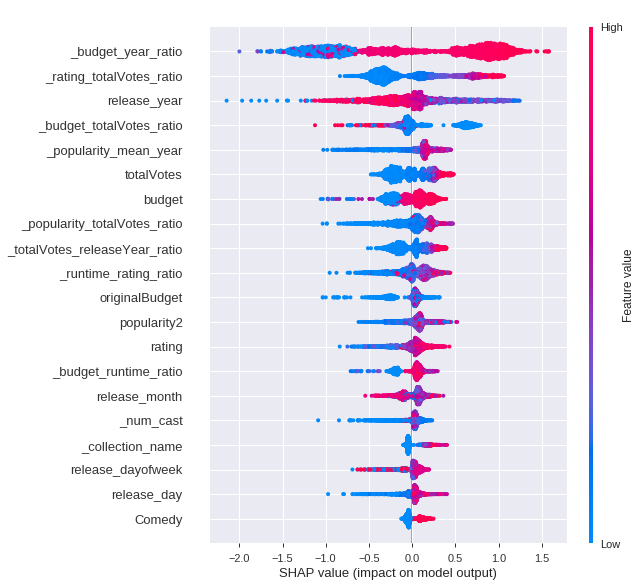

In [70]:
explainer = shap.TreeExplainer(model1, x_train)
shap_values = explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train)

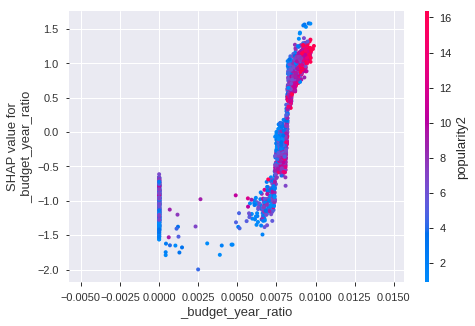

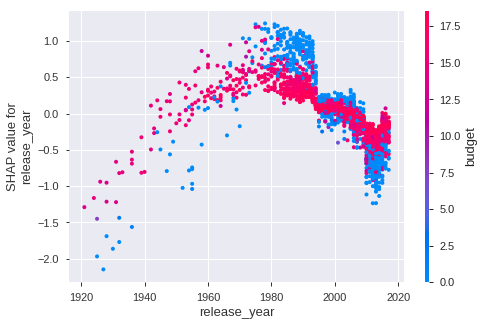

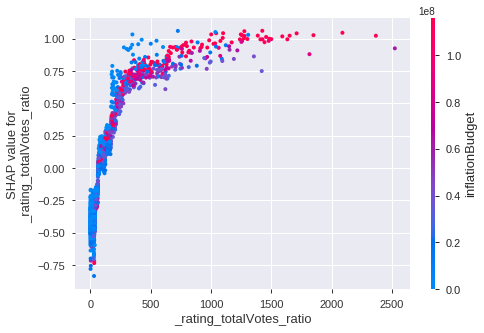

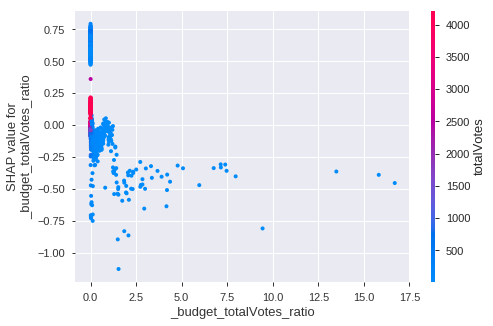

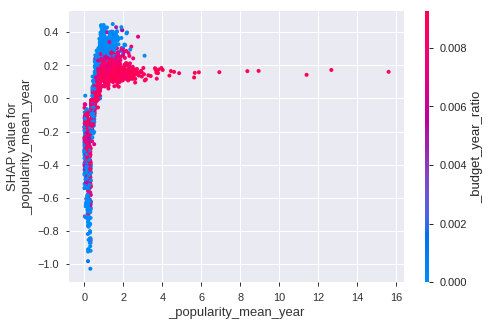

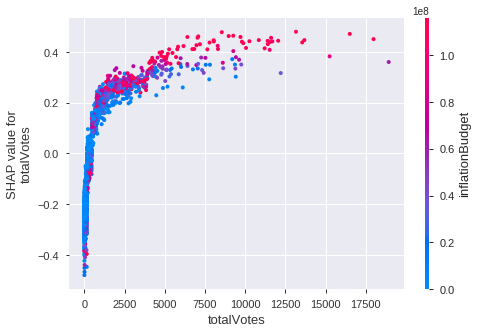

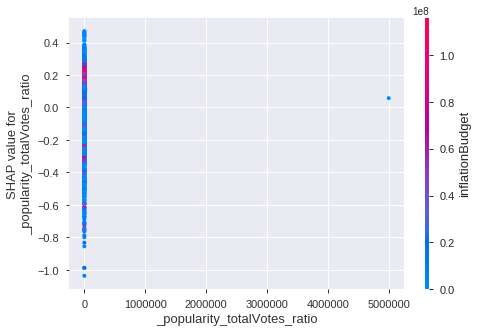

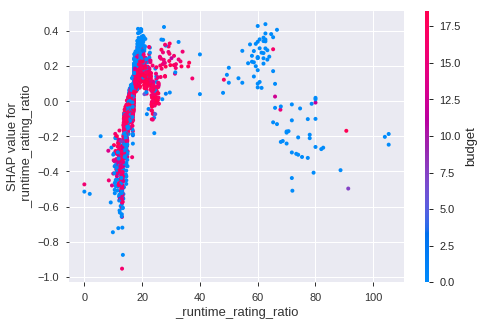

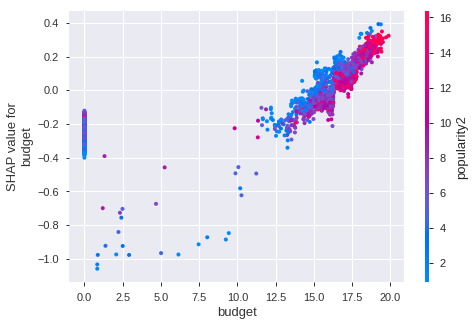

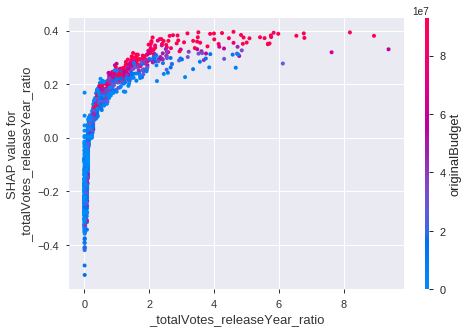

In [71]:
top_columns = x_train.columns[np.argsort(shap_values.std(0))[::-1]][:10]
for col in top_columns:
    shap.dependence_plot(col, shap_values, x_train)

## XGBoost, LightGBM, CatBoost models
For actual training, I intend to use XGBoost, LightGBM, and CatBoost models, with K-fold cross validation with 6 splits (k=6). Will use a blended error score

Setting up 6-fold validation with shuffling


In [72]:
random_seed = 200
n_fold = 6
folds = KFold(n_splits=n_fold, shuffle=True, random_state= random_seed)

### Reusable train function, for training chosen algorithms

In [73]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        
        X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

### Train LightGBM

Fold 0 started at Sun Aug 25 12:24:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.35149	valid_1's rmse: 2.04582
Early stopping, best iteration is:
[961]	training's rmse: 1.37031	valid_1's rmse: 2.04519
Fold 1 started at Sun Aug 25 12:24:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.35755	valid_1's rmse: 2.04884
[2000]	training's rmse: 1.03973	valid_1's rmse: 2.0326
Early stopping, best iteration is:
[2346]	training's rmse: 0.955397	valid_1's rmse: 2.02943
Fold 2 started at Sun Aug 25 12:24:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.356	valid_1's rmse: 2.11877
[2000]	training's rmse: 1.03922	valid_1's rmse: 2.10619
Early stopping, best iteration is:
[2143]	training's rmse: 1.00494	valid_1's rmse: 2.10475
Fold 3 started at Sun Aug 25 12:24:21 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.

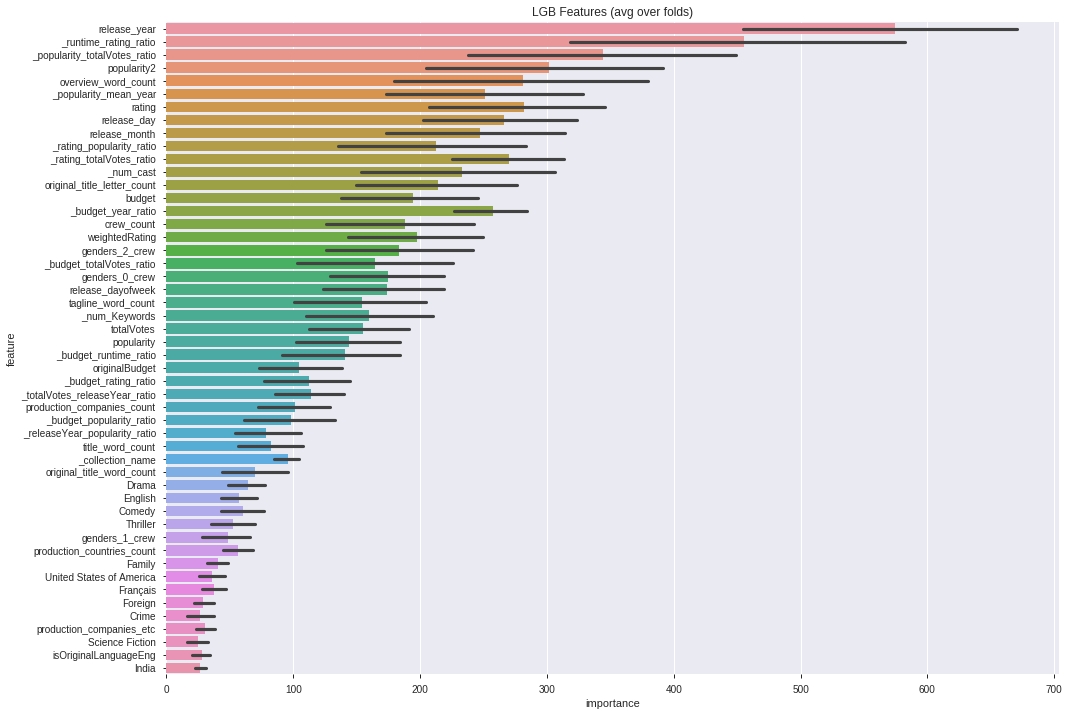

In [74]:
params = {'objective':'regression',
         'num_leaves' : 30,
         'min_data_in_leaf' : 20,
         'max_depth' : 9,
         'learning_rate': 0.004,
         'min_child_samples':100,
         'feature_fraction':0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         'lambda_l1': 0.2,
         "bagging_seed": random_seed,
         "metric": 'rmse',
         'subsample':.8, 
         'colsample_bytree':.9,
         "random_state" : random_seed,
         "verbosity": -1}
oof_lgb, prediction_lgb, _ = train_model(train, test, y, params=params, model_type='lgb', 
                                         plot_feature_importance=True)

### Train XGBoost

In [75]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 6,
              'subsample': 0.6,
              'colsample_bytree': 0.7,
              'eval_metric': 'rmse',
              'seed': 25,
              'silent': True}
oof_xgb, prediction_xgb = train_model(train, test, y, params=xgb_params, model_type='xgb')

Fold 0 started at Sun Aug 25 12:24:43 2019
[0]	train-rmse:15.6176	valid_data-rmse:15.5637
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.21579	valid_data-rmse:2.03961
[1000]	train-rmse:0.847146	valid_data-rmse:2.01592
Stopping. Best iteration:
[1102]	train-rmse:0.791398	valid_data-rmse:2.01326

Fold 1 started at Sun Aug 25 12:24:58 2019
[0]	train-rmse:15.5979	valid_data-rmse:15.6605
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.20542	valid_data-rmse:2.07111
[1000]	train-rmse:0.846431	valid_data-rmse:2.02535
[1500]	train-rmse:0.628602	valid_data-rmse:2.01456
Stopping. Best iteration:
[1764]	train-rmse:0.53903	valid_data-rmse:2.01324

Fold 2 started at Sun Aug 25 12:25:23 2019
[0]	train-rmse:15.5988	valid_data-rmse:15.6526
Multiple eva

### Train CatBoost

In [76]:
cat_params = {'learning_rate': 0.004,
              'depth': 5,
              'l2_leaf_reg': 10,
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': random_seed,
              'allow_writing_files': False}

oof_cat, prediction_cat = train_model(train, test, y, params=cat_params, model_type='cat')

Fold 0 started at Sun Aug 25 12:26:48 2019
Fold 1 started at Sun Aug 25 12:28:12 2019
Fold 2 started at Sun Aug 25 12:29:12 2019
Fold 3 started at Sun Aug 25 12:30:11 2019
Fold 4 started at Sun Aug 25 12:34:33 2019
Fold 5 started at Sun Aug 25 12:37:30 2019
CV mean score: 2.0140, std: 0.0752.


### Build stack of all 3 models and train the stack

In [77]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack, columns=['lgb', 'xgb', 'cat'])

Fold 0 started at Sun Aug 25 12:40:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[700]	training's rmse: 1.90865	valid_1's rmse: 2.00362
Fold 1 started at Sun Aug 25 12:40:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[289]	training's rmse: 1.95417	valid_1's rmse: 2.0395
Fold 2 started at Sun Aug 25 12:40:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[589]	training's rmse: 1.89452	valid_1's rmse: 2.11975
Fold 3 started at Sun Aug 25 12:40:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[294]	training's rmse: 1.95406	valid_1's rmse: 2.04168
Fold 4 started at Sun Aug 25 12:40:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[541]	training's rmse: 1.94317	valid_1's rmse: 1.96711
Fold 5 started at Sun

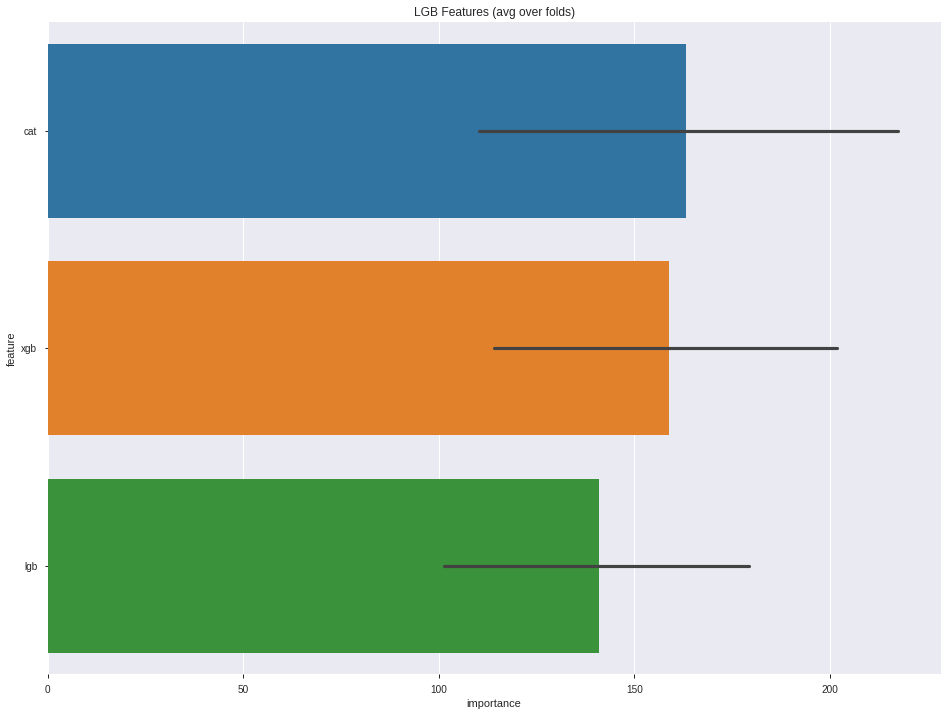

In [78]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack, prediction_lgb_stack, _ = train_model(train_stack, test_stack, y, 
                                                     params=params, model_type='lgb', plot_feature_importance=True)

# Predictions

Now with training of the 3 chosen modeling techniques and stacked model with all 3 in-place, let us tackle predictions on test dataset, and see how closely they are matching with one another, and pick final model

In [79]:
sub = pd.read_csv('data/sample_submission.csv')
all_pred = pd.read_csv('data/sample_submission.csv')
sub['revenue'] = np.expm1(prediction_lgb)
sub.to_csv("output/lgb.csv", index=False)
all_pred['pred_lgb'] = np.expm1(prediction_lgb)

sub['revenue'] = np.expm1(prediction_xgb)
sub.to_csv("output/xgb.csv", index=False)
all_pred['pred_xgb'] = np.expm1(prediction_xgb)
                          
sub['revenue'] = np.expm1(prediction_cat)
sub.to_csv("output/cat.csv", index=False)
all_pred['pred_cat'] = np.expm1(prediction_cat)
                          
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb) / 2)
sub.to_csv("output/blend_lgb_xgb.csv", index=False)
all_pred['pred_blend_lgb_xgb'] = np.expm1((prediction_lgb + prediction_xgb) / 2)
                          
sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat) / 3)
sub.to_csv("output/blend_all3.csv", index=False)
all_pred['pred_blend_all3'] = np.expm1((prediction_lgb + prediction_xgb + prediction_cat) / 3)

sub['revenue'] = prediction_lgb_stack
sub.to_csv("output/stack_lgb.csv", index=False)
all_pred['pred_stack_lgb'] = np.expm1(prediction_lgb_stack)

In [80]:
all_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 8 columns):
id                    4398 non-null int64
revenue               4398 non-null int64
pred_lgb              4398 non-null float64
pred_xgb              4398 non-null float64
pred_cat              4398 non-null float64
pred_blend_lgb_xgb    4398 non-null float64
pred_blend_all3       4398 non-null float64
pred_stack_lgb        4398 non-null float64
dtypes: float64(6), int64(2)
memory usage: 275.0 KB


### Visualize correlation as HeatMap across various models

Visualizing the HeatMap, blend of all 3 models `pred_blend_all3` is shows very high correlation, perfect correlation with 2 other models and 0.99 correlation with 2 other. I am going to pick that as my final model.


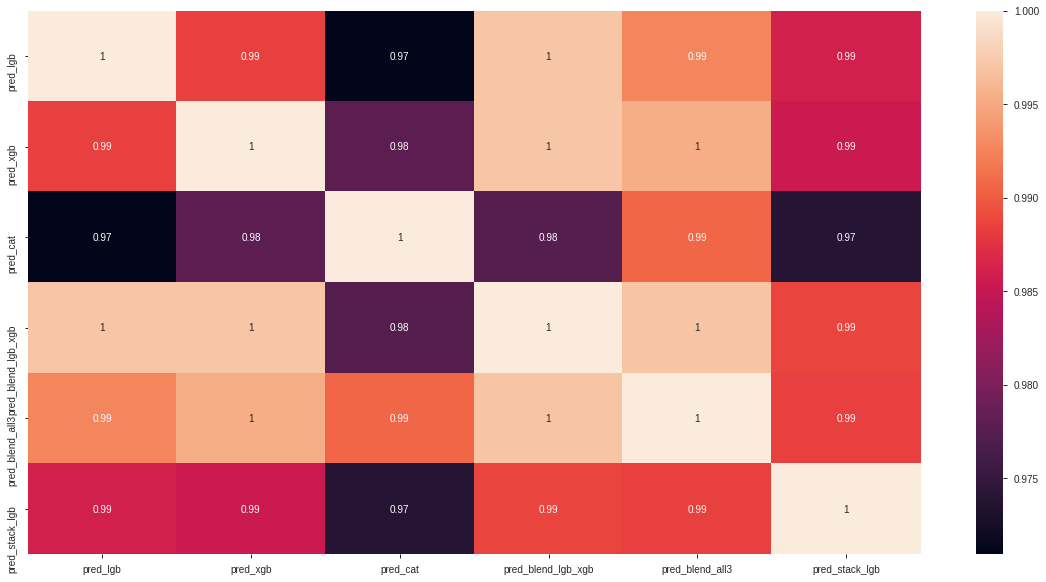

In [81]:
pred_viz = all_pred[['pred_lgb','pred_xgb','pred_cat','pred_blend_lgb_xgb','pred_blend_all3','pred_stack_lgb']]
f,ax = plt.subplots(figsize=(20, 10))
sns.heatmap(pred_viz.corr(), annot=True)
plt.show()

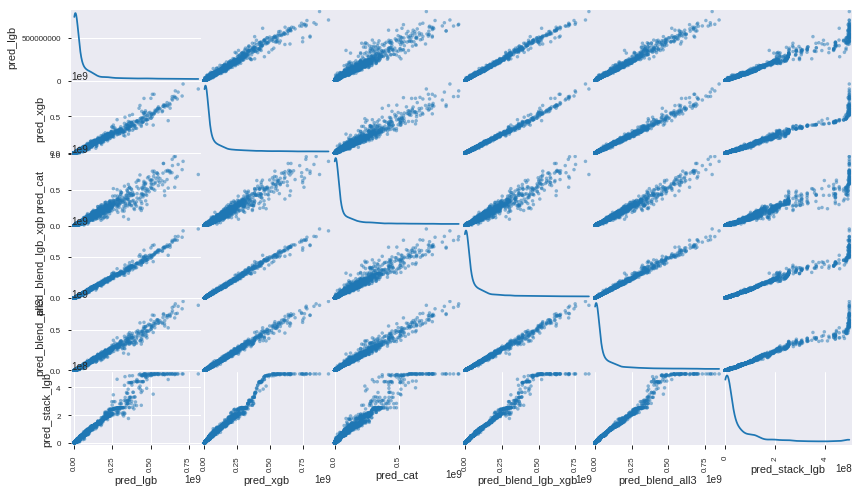

In [82]:
pd.plotting.scatter_matrix(pred_viz, alpha = 0.5, figsize = (14,8), diagonal = 'kde');